# EPL Football Match Prediction 
## ...  Exploring the efficacy of different feature engineering techniques ...

In [1]:
#### Importing libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import ceil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix,  roc_auc_score
from scipy.stats import pointbiserialr


# Classification algorithms
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

## Data pre-processing and cleaning
- View the head of the df
- Drop a few insignificant columns
- Rename some entries of the "team name" column to match the "opponent" column
- Check NaN values and column dtypes
- Number of unique teams in our dataframe and how many games of each team

In [2]:
df = pd.read_csv('all_matches3.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,date,time,comp,round,day,venue,result,gf,...,crspa,prgp,sca,gca,crs,int,tklw,recov,season,team name
0,0,0,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Away,D,1.0,...,2.0,34.0,24.0,2.0,12.0,10.0,9.0,62.0,2023,Liverpool
1,1,1,2023-08-19,15:00,Premier League,Matchweek 2,Sat,Home,W,3.0,...,0.0,40.0,40.0,4.0,16.0,11.0,11.0,58.0,2023,Liverpool
2,2,2,2023-08-27,16:30,Premier League,Matchweek 3,Sun,Away,W,2.0,...,0.0,26.0,16.0,3.0,16.0,8.0,7.0,42.0,2023,Liverpool
3,3,3,2023-09-03,14:00,Premier League,Matchweek 4,Sun,Home,W,3.0,...,1.0,41.0,32.0,2.0,13.0,8.0,9.0,56.0,2023,Liverpool
4,4,4,2023-09-16,12:30,Premier League,Matchweek 5,Sat,Away,W,3.0,...,4.0,73.0,30.0,4.0,18.0,9.0,16.0,57.0,2023,Liverpool


In [3]:
# Define the mapping of values to be replaced with their replacements
mapping = {
    "Manchester United": "Manchester Utd",
    "Brighton and Hove Albion": "Brighton",
    "Wolverhampton Wanderers": "Wolves",
    "West Ham United": "West Ham",
    "Newcastle United": "Newcastle Utd",
    "Tottenham Hotspur": "Tottenham",
    "Nottingham Forest": "Nott'ham Forest",
    "Sheffield United": "Sheffield Utd"
}

# Replace values in the 'team name' column using the defined mapping
df['team name'] = df['team name'].replace(mapping)


# Drop insignificant columns 
df = df.drop(df.columns[:2], axis=1)
cols_to_drop = ['attendance',  'referee', 'match report', 'notes']
df = df.drop(columns=cols_to_drop)
print("Shape of the dataframe after dropping irrelevant columns is",df.shape)

Shape of the dataframe after dropping irrelevant columns is (2056, 42)


In [4]:
# See which columns has NaN values
nan_values = df.isna().sum()
non_zero_nans = nan_values[nan_values > 0]
print("\nCount of NaN values in each column (only those with non-zero NaNs):")
print(non_zero_nans)


Count of NaN values in each column (only those with non-zero NaNs):
g/sot    58
dtype: int64


Only the column "g/sot" has NaN values, and that too very few(58) compared to the size of the dataset

In [5]:
# Column datatypes
print(df.dtypes)

date          object
time          object
comp          object
round         object
day           object
venue         object
result        object
gf           float64
ga           float64
opponent      object
xg           float64
xga          float64
poss         float64
captain       object
formation     object
sh           float64
sot          float64
sot%         float64
g/sh         float64
g/sot        float64
dist         float64
fk           float64
pk             int64
pkatt          int64
cmp          float64
att          float64
cmp%         float64
totdist      float64
prgdist      float64
kp           float64
1/3          float64
ppa          float64
crspa        float64
prgp         float64
sca          float64
gca          float64
crs          float64
int          float64
tklw         float64
recov        float64
season         int64
team name     object
dtype: object


In [5]:
# Convert the date column's data type to datetime
df["date"] = pd.to_datetime(df["date"])

In [6]:
print("Number of unique teams in our df =", df["team name"].nunique())
df["team name"].value_counts()

Number of unique teams in our df = 25


Liverpool          103
Manchester City    103
Arsenal            103
Aston Villa        103
Everton            103
Manchester Utd     103
West Ham           103
Newcastle Utd      103
Brighton           103
Wolves             103
Brentford          103
Crystal Palace     103
Chelsea            102
Tottenham          102
Leicester City      76
Southampton         76
Leeds United        76
Fulham              65
Nott'ham Forest     65
Burnley             65
Bournemouth         64
Watford             38
Norwich City        38
Sheffield Utd       27
Luton Town          26
Name: team name, dtype: int64

### Explanation of the above counts
- 20 teams play at the Premier League every season and each team plays 38 matches each season
- After 38 rounds of home and away leg fixtures, the last 3 teams, i.e the teams ranked 18th, 19th and 20th, are relegated to the Football League Championship.
- Their spots are taken by the top 2 teams from the Football League Championship and a 3rd team that qualifies after winning the play-offs involving the 3rd-6th placed teams of the Football League Championship!
- The data was scraped for 3 seasons including the current season which is ongoing
- Hence different teams have different number of matches, depending on what seasons they played and are playing 

## EDA : Feature Engineering and Data Visualistion 

### 1. Creating meaningful features
- Some teams may play well during the day time, some may play night matches well

    - Create column "hour" out of date

- Convert venue(Categorical variable) to a numeric variable 
    - Use Label Encoding first then try out One hot encoding
  
  
- Creating the target feature [WIN = 1, DRAW/LOSE = 0] based off the column "team name"
    - Here, we predict if a team would WIN or NOT WIN(LOSE/DRAW) i.e Binary classification problem

In [7]:
venue_mapping = {'Home': 0, 'Away': 1}
df['venue_numeric'] = df['venue'].map(venue_mapping)

# Use label encoding to encode the opponent column
df['opponent_id'] = df['opponent'].astype('category').cat.codes

# Create column hour out of date
df["hour"] = df["time"].str.replace(":.+","", regex=True).astype("int")

# If the team in the column "team name"  WIN = 1, DRAW/LOSE = 0
df["target"] = (df["result"] == "W").astype("int")
df.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,crs,int,tklw,recov,season,team name,venue_numeric,opponent_id,hour,target
0,2023-08-13,16:30,Premier League,Matchweek 1,Sun,Away,D,1.0,1.0,Chelsea,...,12.0,10.0,9.0,62.0,2023,Liverpool,1,6,16,0
1,2023-08-19,15:00,Premier League,Matchweek 2,Sat,Home,W,3.0,1.0,Bournemouth,...,16.0,11.0,11.0,58.0,2023,Liverpool,0,2,15,1
2,2023-08-27,16:30,Premier League,Matchweek 3,Sun,Away,W,2.0,1.0,Newcastle Utd,...,16.0,8.0,7.0,42.0,2023,Liverpool,1,16,16,1
3,2023-09-03,14:00,Premier League,Matchweek 4,Sun,Home,W,3.0,0.0,Aston Villa,...,13.0,8.0,9.0,56.0,2023,Liverpool,0,1,14,1
4,2023-09-16,12:30,Premier League,Matchweek 5,Sat,Away,W,3.0,1.0,Wolves,...,18.0,9.0,16.0,57.0,2023,Liverpool,1,24,12,1


### 2. Home team results Visualisation
-  Teams play well at home conditions, hence the term "home advantage"
- Hence the "venue" encoding being used as a feature
- At a team specific level, some teams play much better at home than others, so we can delve deeper into team specific details 

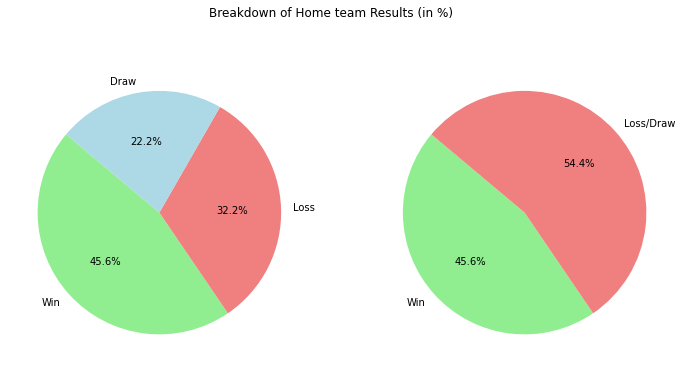

In [8]:
# Visualise the home team won %, draw or loss%
home_matches = df[df["venue"] == "Home"]
result_counts = home_matches["result"].value_counts()
total_matches = home_matches.shape[0]

win_percent = result_counts.get('W', 0)*100/total_matches
loss_percent = result_counts.get('L', 0)*100/total_matches
draw_percent = result_counts.get('D', 0)*100/total_matches
y1 = [win_percent, loss_percent, draw_percent]
labels1 = ["Win", "Loss", "Draw"]
colors_home1 = ['lightgreen', 'lightcoral', 'lightblue']

y2 = [win_percent, loss_percent + draw_percent]
labels2 = ["Win", "Loss/Draw"]
colors_home2 = ['lightgreen',  'lightcoral']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(y1, labels = labels1, colors=colors_home1, autopct='%1.1f%%', startangle=140)

plt.subplot(1, 2, 2)
plt.pie(y2, labels = labels2, colors=colors_home2, autopct='%1.1f%%', startangle=140)
plt.suptitle("Breakdown of Home team Results (in %)")
plt.show() 

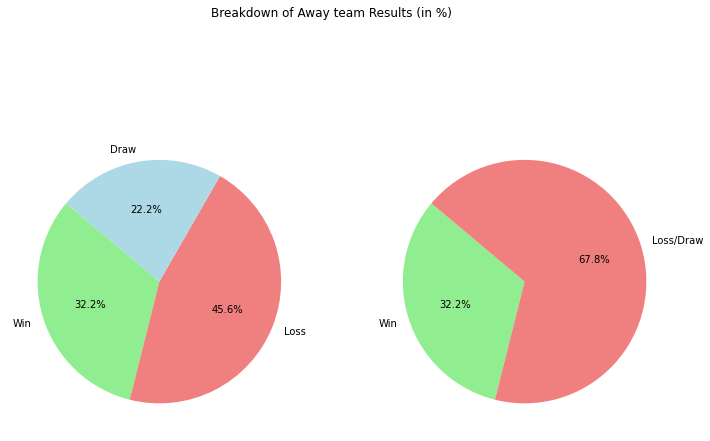

In [9]:
# Visualise the home team won %, draw or loss%
away_matches = df[df["venue"] == "Away"]
result_counts = away_matches["result"].value_counts()
total_matches = away_matches.shape[0]

win_percent = result_counts.get('W', 0)*100/total_matches
loss_percent = result_counts.get('L', 0)*100/total_matches
draw_percent = result_counts.get('D', 0)*100/total_matches
y1 = [win_percent, loss_percent, draw_percent]
labels1 = ["Win", "Loss", "Draw"]
colors_home1 = ['lightgreen', 'lightcoral', 'lightblue']

y2 = [win_percent, loss_percent + draw_percent]
labels2 = ["Win", "Loss/Draw"]
colors_home2 = ['lightgreen',  'lightcoral']


plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.pie(y1, labels = labels1, colors=colors_home1, autopct='%1.1f%%', startangle=140)

plt.subplot(1, 2, 2)
plt.pie(y2, labels = labels2, colors=colors_home2, autopct='%1.1f%%', startangle=140)
plt.suptitle("Breakdown of Away team Results (in %)")
plt.show() 

### 2.1 Team-specific visualisation
#### a) Visualise Home win percentage V/s Away Win percentage
- The visualisation shows that certain teams play better at home/away
- So, we need to incorporate some feature which captures this
- They can be 
    - Avg number of home wins of the home team in the last 10 or 15 matches
    - Avg number of away wins of the away team in the last 10 or 15 matches 

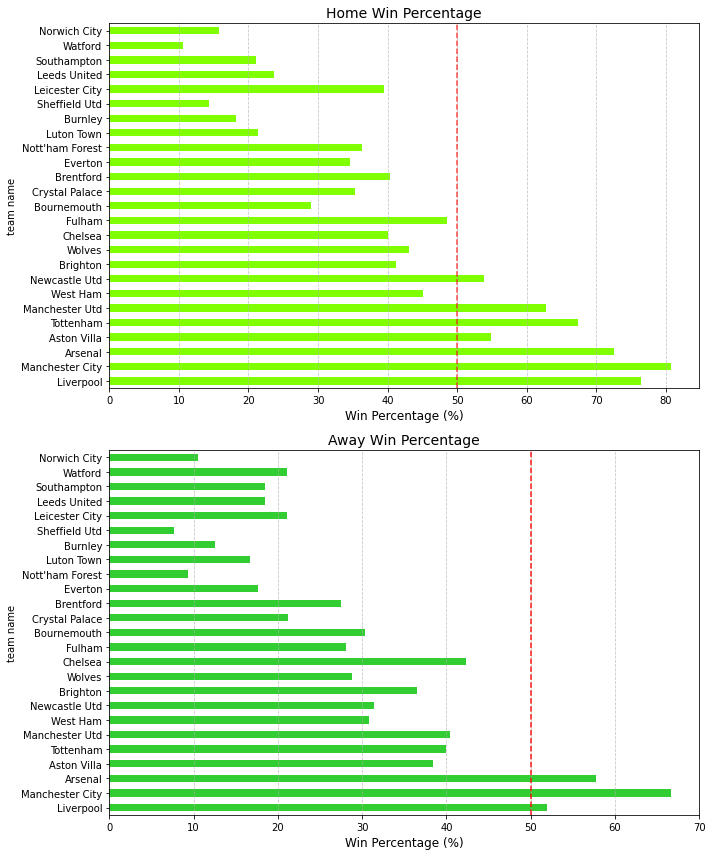

In [10]:
import matplotlib.pyplot as plt

# Create subsets for Home and Away
temp_df1 = df[df["venue"] == 'Home'].copy()
temp_df2 = df[df["venue"] == 'Away'].copy()

# Calculate Home and Away Win Percentages
temp_df1.loc[:, 'home_win_percentage'] = temp_df1.groupby('team name')['target'].transform('mean') * 100
temp_df2.loc[:, 'away_win_percentage'] = temp_df2.groupby('team name')['target'].transform('mean') * 100

# Calculate Goals Scored and Conceded at Home and Away
temp_df1.loc[:, 'goals_scored_home'] = temp_df1.groupby('team name')['gf'].transform('sum')
temp_df1.loc[:, 'goals_conceded_home'] = temp_df1.groupby('team name')['ga'].transform('sum')
temp_df2.loc[:, 'goals_scored_away'] = temp_df2.groupby('team name')['gf'].transform('sum')
temp_df2.loc[:, 'goals_conceded_away'] = temp_df2.groupby('team name')['ga'].transform('sum')

# Plotting Horizontal Bar Charts
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Home Win Percentage
temp_df1.drop_duplicates(subset=['team name']).plot(kind='barh', x='team name', y='home_win_percentage',
                                               ax=axes[0], color='#7FFF00', legend=False)
axes[0].set_title('Home Win Percentage', fontsize=14)
axes[0].set_xlabel('Win Percentage (%)', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[0].axvline(x=50, linestyle='--', color='red', alpha=0.7)  

# Away Win Percentage
temp_df2.drop_duplicates(subset=['team name']).plot(kind='barh', x='team name', y='away_win_percentage',
                                               ax=axes[1], color='#32CD32', legend=False)
axes[1].set_title('Away Win Percentage', fontsize=14)
axes[1].set_xlabel('Win Percentage (%)', fontsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].axvline(x=50, linestyle='--', color='red', alpha=0.9)  

plt.tight_layout()
plt.show()


### Observations: 

From the Home Win percentage graph, it is clear that teams like **Liverpool, Manchester City,  Manchester City, Arsenal which are considered to be strong teams have higher win rates at home than other clubs**  

Similarly, we can see from the Away Win percentage graph, most teams more often than not loses at Away ground barring
**Manchester City, Liverpool, Arsenal**

#### b) Visualise Home Goals scored/conceded V/s Away Goals scored/conceded
- The visualisation shows that certain teams score better at home/away
- So, we need to incorporate some feature which captures this
- They can be 
    - Number of goals scored and conceded by the home team in the last 10 Home matches
    - Number of goals scored and conceded by the away team in the last 10 Away matches
    
These intuitive maybe-useful features are Incorporated later during feature creation

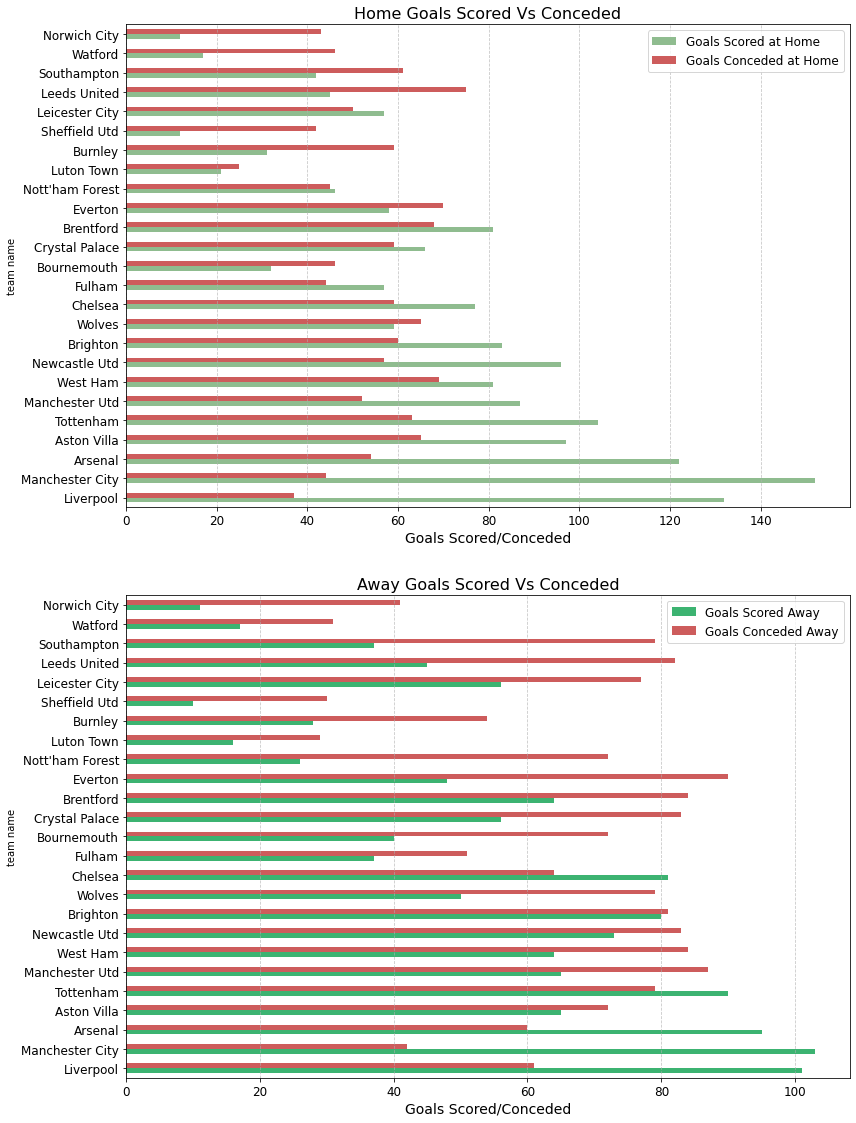

In [11]:
import matplotlib.pyplot as plt

colors_home = ['#8FBC8F', '#CD5C5C']  
colors_away = ['#3CB371', '#CD5C5C']  


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))

# Plotting Home Goals Scored Vs Conceded
temp_df1.drop_duplicates(subset=['team name']).plot(kind='barh', x='team name', y=['goals_scored_home', 'goals_conceded_home'],
                                                    ax=axes[0], color=colors_home)
axes[0].legend(['Goals Scored at Home', 'Goals Conceded at Home'], fontsize=12)
axes[0].set_title('Home Goals Scored Vs Conceded', fontsize=16)
axes[0].set_xlabel('Goals Scored/Conceded', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# Plotting Away Goals Scored Vs Conceded
temp_df2.drop_duplicates(subset=['team name']).plot(kind='barh', x='team name', y=['goals_scored_away', 'goals_conceded_away'],
                                                    ax=axes[1], color=colors_away)
axes[1].legend(['Goals Scored Away', 'Goals Conceded Away'], fontsize=12)
axes[1].set_title('Away Goals Scored Vs Conceded', fontsize=16)
axes[1].set_xlabel('Goals Scored/Conceded', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.subplots_adjust(hspace=100)  # Adjust vertical spacing between subplots


plt.tight_layout()
plt.show()


### 3. Check point biserial correlation
- The Point-Biserial Correlation is a special case of the Pearson Correlation and is used when you want to measure the relationship between a continuous variable and a dichotomous variable, or one that has two values (i.e. male/female, yes/no, true/false).
- Assumptions
    1. No outliers (continuous variable) - assessed through a visual examination of the scatterplot
    2. Approximately normally distributed (continuous variable)

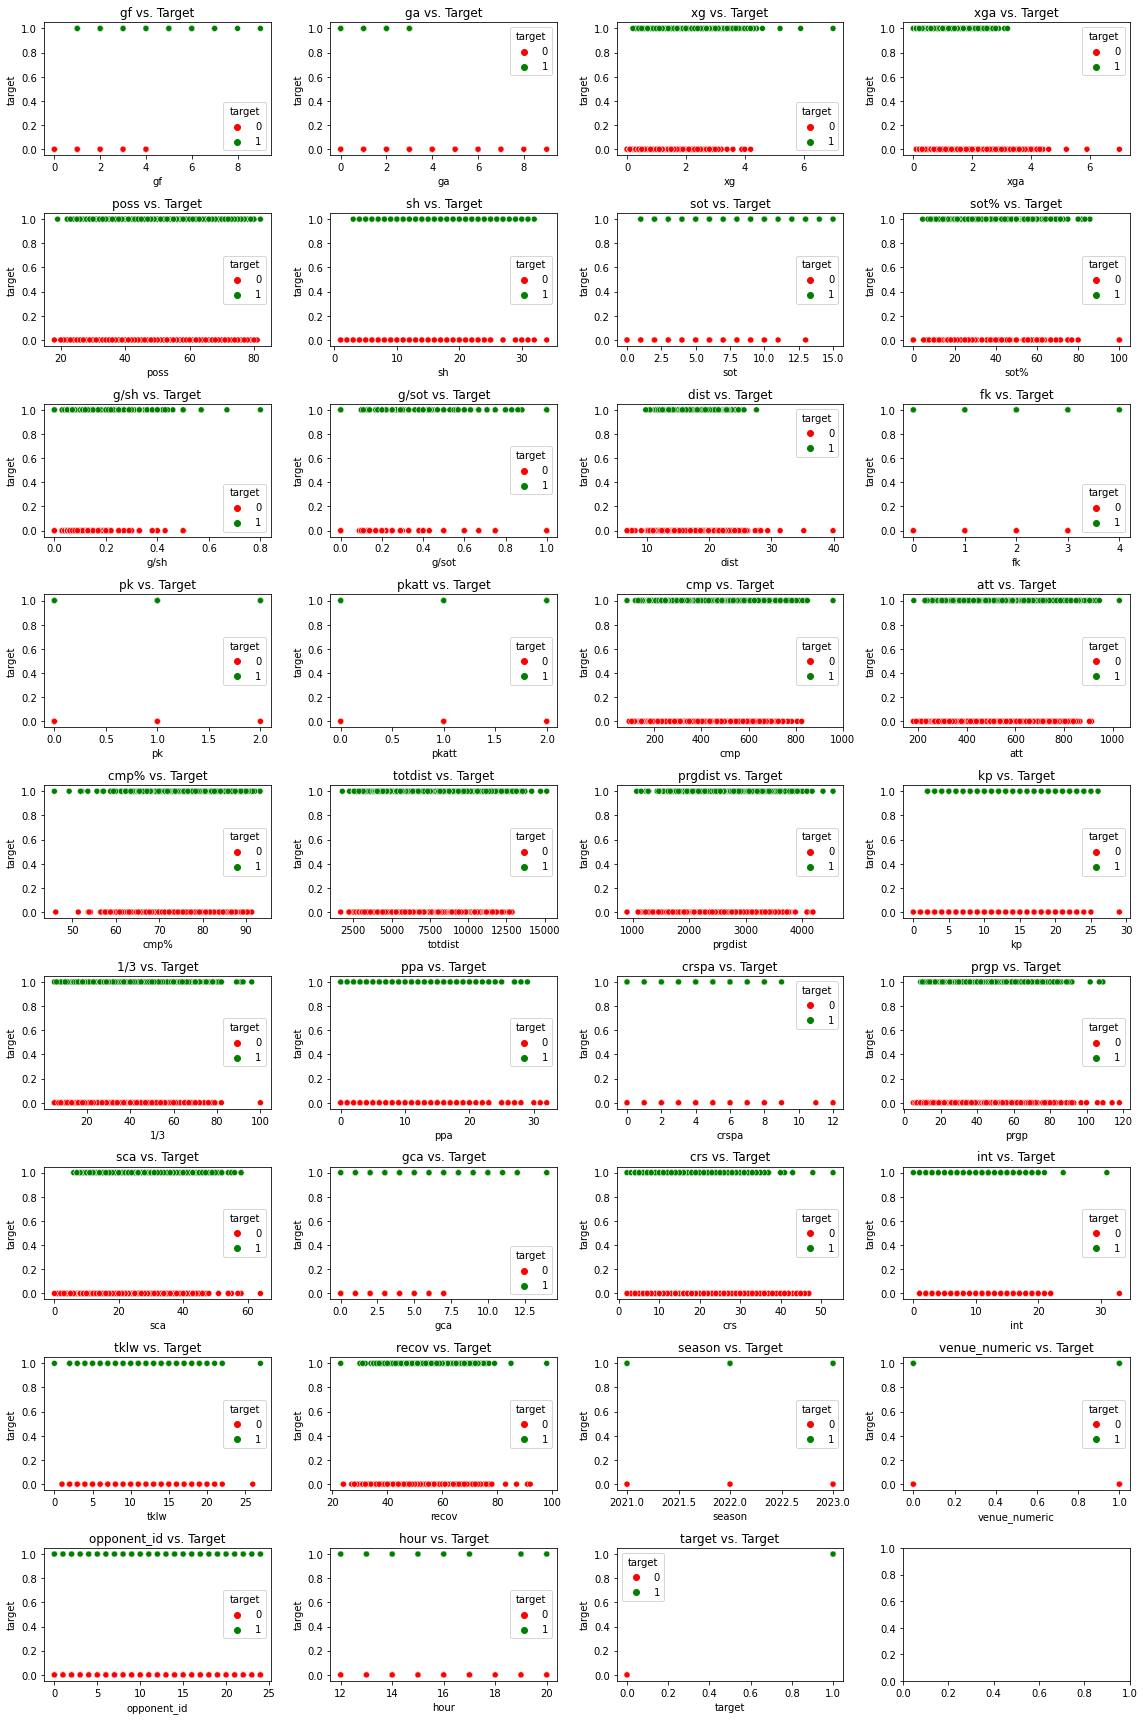

In [12]:
# Selecting only numerical features for demonstration
numerical_features = df.select_dtypes(include='number')

# Set up subplots with multiple rows
num_rows = 9
num_cols = ceil((len(numerical_features.columns) - 1)/num_rows) # Exclude 'target' column
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 24))

axes = axes.flatten()

# Plot scatterplots for each numerical feature
for i, column in enumerate(numerical_features.columns):
    sns.scatterplot(x=column, y='target', data=df, ax=axes[i], hue='target', palette={0: 'red', 1: 'green'})
    axes[i].set_title(f'{column} vs. Target')

plt.tight_layout()
plt.show()

- Not much to infer from these plots 
- However, some features are self-explanatorarily important and is shown by these plots as well.
- For example, "gf"(goals for) and "ga"(goals against) have positive and negative correlation with wins 

### 4. Feature selection techniques
-
-
-
-

In [13]:
def compute_rolling_averages(df, columns, window_size, new_column_suffix='_rolling_avg', home=True):
    """
        Compute rolling averages for specific columns in a pandas DataFrame and 
                        assign them to new columns in the same DataFrame.

    Arguments :
        df (pandas DataFrame): The input DataFrame.
        columns (list of str): The names of the columns to compute rolling averages for.
        window_size (int): The size of the rolling window.
        new_column_suffix (str, optional): The suffix to append to the names of the new columns. Defaults to '_rolling_avg'.

    Returns:
        pandas DataFrame: The updated DataFrame with the rolling average columns.
                                                                                                                """
    
    # Sort if already not sorted
    df = df.sort_values("date")
    new_column_names = []
    
    for column in columns:
        new_column_name = column + new_column_suffix
        new_column_names.append(new_column_name)
        
        # Calculate rolling averages with available rows if less than window size
        df.loc[:, new_column_name] = df[column].rolling(min_periods=1, window=window_size, closed='left').mean()
    
    df = df.dropna(subset=new_column_names)
    
    return df



def predict(train_data, test_data, features, model):
    """
    Fits the model on the training data using the specified features and target column, makes predictions on the test data.
    It then creates a pandas DataFrame that contains both the actual target values and the predicted target values, 
    with the index set to the index of the test data. Computes the precision score as well.

    Args:
        train_data: a pandas DataFrame containing the training data
        test_data: a pandas DataFrame containing the testing data
        features: a list of strings containing the names of the features to use 
        model: a machine learning model object with a fit() and predict() method.

    Returns:
        combined: a pandas DataFrame that contains both the actual target values and the predicted target values
        accuracy: accuracy score
        precision: precision score
        f1: F1 score
        recall: recall score
        confusion_mat: confusion matrix
                                                                                                                                """
    model.fit(train_data[features], train_data["target"])
    preds = model.predict(test_data[features])
    combined = pd.DataFrame(dict(actual=test_data["target"], predicted=preds), index=test_data.index)
    accuracy = accuracy_score(test_data["target"], preds)
    precision = precision_score(test_data["target"], preds)
    recall = recall_score(test_data["target"], preds)
    f1 = f1_score(test_data["target"], preds)
    confusion_mat = confusion_matrix(test_data["target"], preds)
    
    return combined, accuracy, precision, f1, recall, confusion_mat


In [14]:
df.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'captain', 'formation', 'sh', 'sot',
       'sot%', 'g/sh', 'g/sot', 'dist', 'fk', 'pk', 'pkatt', 'cmp', 'att',
       'cmp%', 'totdist', 'prgdist', 'kp', '1/3', 'ppa', 'crspa', 'prgp',
       'sca', 'gca', 'crs', 'int', 'tklw', 'recov', 'season', 'team name',
       'venue_numeric', 'opponent_id', 'hour', 'target'],
      dtype='object')

In [15]:
# All columns included
cols_list = ["gf", "ga", "sh", "sot", "sot%" , "g/sh", "g/sot", "dist", "pk", "pkatt", "poss", "xg", "xga", 
             'cmp%', 'totdist','prgdist', 'kp', '1/3', 'ppa', 'prgp', 'sca', 'gca', 'recov', 
             "cmp", "att", 'fk', 'crspa', 'crs', 'int', 'tklw']

#### o   Compute rolling averages of previous match statistics

In [16]:
all_matches_rolling = df.groupby("team name").apply(lambda x: compute_rolling_averages(x, cols_list, 3))
all_matches_rolling.index = range(all_matches_rolling.shape[0])
print(f"The shape of our new dataframe all_matches_rolling = {all_matches_rolling.shape}\n")
all_matches_rolling.head()

The shape of our new dataframe all_matches_rolling = (2029, 76)



,date,time,comp,round,day,venue,result,gf,ga,opponent,...,sca_rolling_avg,gca_rolling_avg,recov_rolling_avg,cmp_rolling_avg,att_rolling_avg,fk_rolling_avg,crspa_rolling_avg,crs_rolling_avg,int_rolling_avg,tklw_rolling_avg
0,2021-08-22,16:30,Premier League,Matchweek 2,Sun,Home,L,0.0,2.0,Chelsea,...,43.000000,0.000000,48.000000,522.000000,620.000000,1.000000,8.000000,22.000000,7.000000,3.000000
1,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Away,L,0.0,5.0,Manchester City,...,27.500000,0.000000,42.500000,404.500000,500.000000,0.500000,5.000000,21.500000,6.500000,10.000000
2,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Home,W,1.0,0.0,Norwich City,...,19.000000,0.000000,39.666667,316.666667,402.333333,0.333333,3.666667,15.333333,8.333333,8.666667
3,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Away,W,1.0,0.0,Burnley,...,22.000000,0.333333,42.666667,274.333333,356.333333,0.333333,2.666667,14.666667,7.000000,11.333333
4,2021-09-26,16:30,Premier League,Matchweek 6,Sun,Home,W,3.0,1.0,Tottenham,...,25.666667,1.000000,46.000000,326.000000,415.333333,0.666667,2.000000,10.666667,8.666667,8.333333


### Case 1: No feature engineering applied
- Train-test split
- Define the features to be used for prediction
- Training and testing using different classification algorithms

In [17]:
# -------------------------------- Train- test data ---------------------------------- #

train_data = all_matches_rolling[all_matches_rolling["date"] < '2023-12-30']
test_data = all_matches_rolling[all_matches_rolling["date"] >= '2023-12-30']
print(f"Shape of our training data is {train_data.shape}")
print(f"Shape of our testing data is {test_data.shape}")
team_counts = test_data['team name'].value_counts()
print("\n")
print(team_counts)

Shape of our training data is (1869, 76)
Shape of our testing data is (160, 76)


Brentford          9
Manchester City    9
Arsenal            8
Aston Villa        8
West Ham           8
Sheffield Utd      8
Nott'ham Forest    8
Newcastle Utd      8
Manchester Utd     8
Luton Town         8
Liverpool          8
Fulham             8
Everton            8
Crystal Palace     8
Burnley            8
Brighton           8
Bournemouth        8
Wolves             8
Chelsea            7
Tottenham          7
Name: team name, dtype: int64


In [29]:
# -------------- Features to use for prediction --------------------- #
# store it in the new_features 

new_columns = []
for column in cols_list:
    new_column_name = column + '_rolling_avg'
    new_columns.append(new_column_name)
    
features = ["venue_numeric", "opponent_id"]
new_features = features + new_columns
print(f"The features we would use for prediction are :- \n\n {new_features}")

The features we would use for prediction are :- 

 ['venue_numeric', 'opponent_id', 'gf_rolling_avg', 'ga_rolling_avg', 'sh_rolling_avg', 'sot_rolling_avg', 'sot%_rolling_avg', 'g/sh_rolling_avg', 'g/sot_rolling_avg', 'dist_rolling_avg', 'pk_rolling_avg', 'pkatt_rolling_avg', 'poss_rolling_avg', 'xg_rolling_avg', 'xga_rolling_avg', 'cmp%_rolling_avg', 'totdist_rolling_avg', 'prgdist_rolling_avg', 'kp_rolling_avg', '1/3_rolling_avg', 'ppa_rolling_avg', 'prgp_rolling_avg', 'sca_rolling_avg', 'gca_rolling_avg', 'recov_rolling_avg', 'cmp_rolling_avg', 'att_rolling_avg', 'fk_rolling_avg', 'crspa_rolling_avg', 'crs_rolling_avg', 'int_rolling_avg', 'tklw_rolling_avg']


### Training and testing using different classification algorithms
Divided into 2 types of classifiers :- 
- Algorithms which are less sensitive to hyper parameters. eg. KNN, Decision Trees, AdaBoost, and Gaussian Naive Bayes etc.
- Algorithms which are very sensitive to hyper parameters. eg. SVM, Gradient Boosting, and Random Forest etc.

And the criteria for finding the best fit hyperparamters is set to be "roc-auc" because : -
-  **Robustness to Class Imbalance**: In the context of our classification task(predicting win or NOT win of football match), the class distribution is imbalanced, with wins being relatively less frequent compared to non-wins (draws or losses). Using accuracy as the metric may lead to misleading interpretations, especially if the majority class (non-wins) dominates. ROC AUC provides a more balanced assessment by considering the trade-off between true positive rate (the proportion of correctly predicted wins) and false positive rate (the proportion of incorrectly predicted non-wins).

- **adada**


Performing RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 5}

Performing RandomizedSearchCV for Gradient Boosting...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}

Performing RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

Performing RandomizedSearchCV for Logistic Regression...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'penalty': 'l2', 'C': 0.01}

Evaluating Random Forest with best hyperparameters:
RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=200)

Performance metrics for Random Forest:
Accuracy: 0.69375
Preci

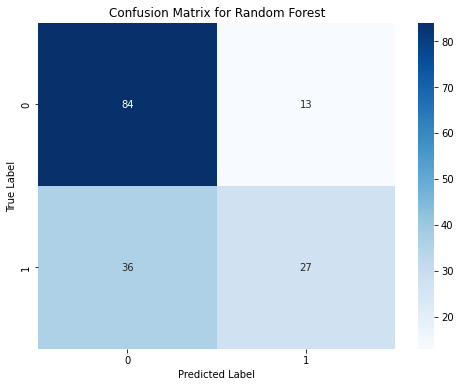

Evaluating Gradient Boosting with best hyperparameters:
GradientBoostingClassifier(learning_rate=0.05)

Performance metrics for Gradient Boosting:
Accuracy: 0.68125
Precision: 0.6578947368421053
F1 Score: 0.4950495049504951
Recall: 0.3968253968253968


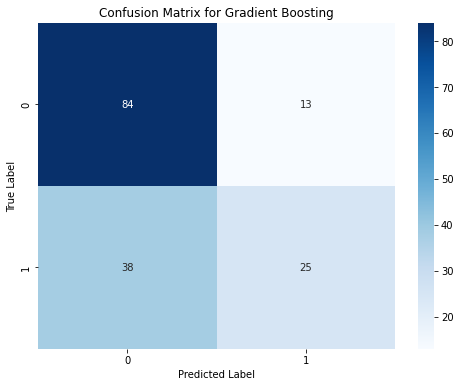

Evaluating XGBoost with best hyperparameters:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Performance metrics for XGBoost:
Accuracy: 0.69375
Precision: 0.675
F1 Score: 0.5242718446601942
Recall: 0.42857142857142855


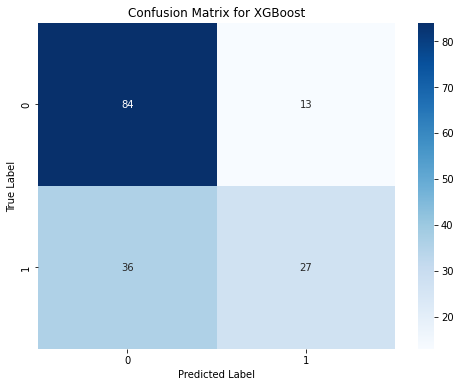

Evaluating Logistic Regression with best hyperparameters:
LogisticRegression(C=0.01)

Performance metrics for Logistic Regression:
Accuracy: 0.6875
Precision: 0.6756756756756757
F1 Score: 0.5
Recall: 0.3968253968253968


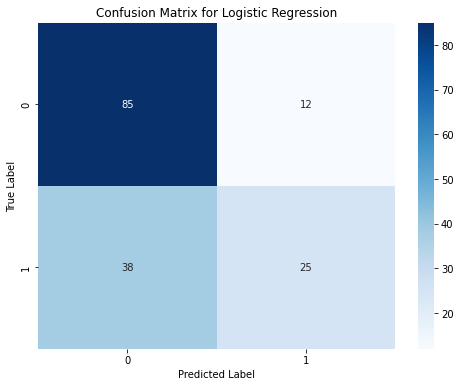

Evaluating Gaussian Naive Bayes...

Performance metrics for Gaussian Naive Bayes:
Accuracy: 0.6625
Precision: 0.5671641791044776
F1 Score: 0.5846153846153845
Recall: 0.6031746031746031


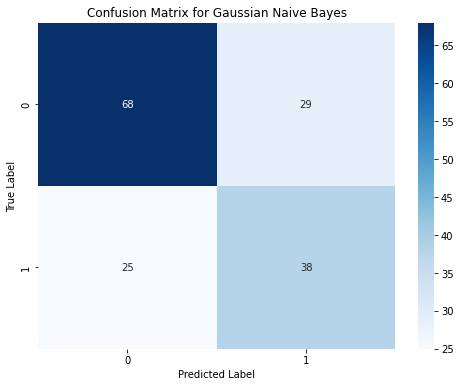

Evaluating Decision Trees...

Performance metrics for Decision Trees:
Accuracy: 0.575
Precision: 0.4626865671641791
F1 Score: 0.4769230769230769
Recall: 0.49206349206349204


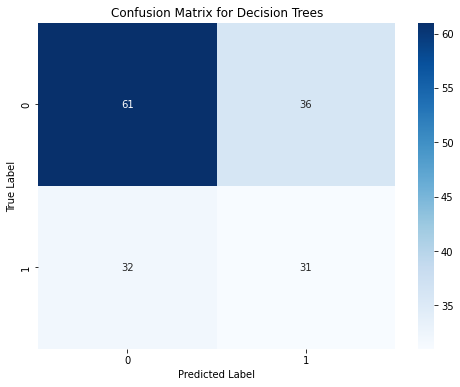

Evaluating AdaBoost...

Performance metrics for AdaBoost:
Accuracy: 0.65625
Precision: 0.5909090909090909
F1 Score: 0.48598130841121495
Recall: 0.4126984126984127


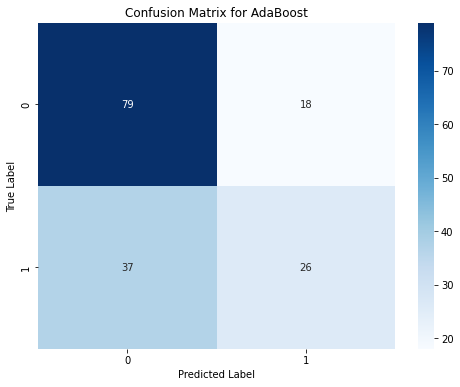

In [20]:
# Split classifiers into two groups
grid_search_classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(objective='binary:logistic'),
    'Logistic Regression': LogisticRegression(solver='lbfgs')
}

default_classifiers = {
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Trees': DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, learning_rate=1.0, base_estimator=None)
}

# Define hyperparameter grids for RandomizedSearchCV
param_distributions = {
    'Random Forest': {'n_estimators': [50, 100, 150, 200],
                      'max_depth': [3, 5, 7, 10, None],
                      'min_samples_split': [2, 5, 10, 15, 20]},
    'Gradient Boosting': {'n_estimators': [50, 100, 150, 200],
                          'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
                          'max_depth': [3, 5, 7, 10]},
    'XGBoost': {'n_estimators': [50, 100, 150, 200, 500],
                'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
                'max_depth': [3, 5, 7, 10],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]},
    'Logistic Regression': {'C': [0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                            'penalty': ['l1', 'l2']}
}

# Perform grid search for hyperparameter tuning
best_estimators = {}
for name, classifier in grid_search_classifiers.items():
    print(f"Performing RandomizedSearchCV for {name}...")
    random_search = RandomizedSearchCV(classifier, param_distributions[name], n_iter=40, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    random_search.fit(train_data[new_features], train_data["target"])
    best_estimators[name] = random_search.best_estimator_
    print(f"Best parameters found: {random_search.best_params_}\n")

    
    
# Use best estimators for classification
for name, classifier in best_estimators.items():
    print(f"Evaluating {name} with best hyperparameters:")
    print(classifier)
    combined, accuracy, precision, f1, recall, confusion_mat = predict(train_data, test_data, new_features, classifier)
    print(f"\nPerformance metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Use default classifiers for classification
for name, classifier in default_classifiers.items():
    print(f"Evaluating {name}...")
    combined, accuracy, precision, f1, recall, confusion_mat = predict(train_data, test_data, new_features, classifier)
    print(f"\nPerformance metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Case 2: Feature creation (to carry some information about the recent team performance)
- 1. **FEATURE CREATION** : Creating new features out of existing features. For example :
    - Avg Number of home team wins in the last 5 HOME matches & 
    - Avg Number of away team's AWAY match wins
    - Goal difference = 'gd'
    - Avg number of goals scored & conceded at home for HOME TEAM => "gd_home"
    - Avg number of goals scored & conceded AWAY for AWAY TEAM => "gd_away"
    
    
- 2. Train-test split
- 3. Define the features to be used for prediction
- 4. Training and testing using different classification algorithms

In [21]:
def calculate_wins(df, window_size=5):
    """
    Calculates the number of wins for each team in the DataFrame based on a rolling window of matches.

    Args:
        df (DataFrame): Input DataFrame containing match data.
        window_size (int): Size of the rolling window to consider for win calculation. Default is 5.

    Returns:
        DataFrame: DataFrame with additional columns 'wins_home' and 'wins_away' representing the number of wins
        for each team in home and away matches, respectively.
    """
    df = df.sort_values(by=['date', 'time'], ascending=[False, False])
    df['wins_away'] = 0
    df['wins_home'] = 0

    for index, row in df.iterrows():
        date_mask = (df['date'] < row['date'])
        time_mask = (df['date'] == row['date']) & (df['time'] < row['time'])

        if row['venue'] == 'Home':
            edit_df = df[(df['team name'] == row['team name']) & (df['venue'] == row['venue']) & (date_mask | time_mask)]
            df.at[index, 'wins_home'] = edit_df['result'].head(window_size).value_counts().get('W', 0)

            edit_df = df[(df['team name'] == row['opponent']) & (df['venue'] == 'Away') & (date_mask | time_mask)]
            df.at[index, 'wins_away'] = edit_df['result'].head(window_size).value_counts().get('W', 0)

        else:
            edit_df = df[(df['team name'] == row['team name']) & (df['venue'] == row['venue']) & (date_mask | time_mask)]
            df.at[index, 'wins_away'] = edit_df['result'].head(window_size).value_counts().get('W', 0)

            edit_df = df[(df['team name'] == row['opponent']) & (df['venue'] == 'Home') & (date_mask | time_mask)]
            df.at[index, 'wins_home'] = edit_df['result'].head(window_size).value_counts().get('W', 0)

    return df


def calculate_goal_difference(df, window_size=5):
    """
    Calculates the goal difference for each team in the DataFrame based on a rolling window of matches.

    Args:
        df (DataFrame): Input DataFrame containing match data.
        window_size (int): Size of the rolling window to consider for goal difference calculation. Default is 5.

    Returns:
        DataFrame: DataFrame with additional columns 'gd_home' and 'gd_away' representing the goal difference
        for each team in home and away matches, respectively.
                                                                                                                """
    df = df.sort_values(by=['date', 'time'], ascending=[False, False])
    df['gd_away'] = 0
    df['gd_home'] = 0

    for index, row in df.iterrows():
        date_mask = (df['date'] < row['date'])
        time_mask = (df['date'] == row['date']) & (df['time'] < row['time'])

        if row['venue'] == 'Home':
            edit_df = df[(df['team name'] == row['team name']) & (df['venue'] == row['venue']) & (date_mask | time_mask)]
            df.at[index, 'gd_home'] = edit_df['gd'].head(window_size).sum()

            edit_df = df[(df['team name'] == row['opponent']) & (df['venue'] == 'Away') & (date_mask | time_mask)]
            df.at[index, 'gd_away'] = edit_df['gd'].head(window_size).sum()

        else:
            edit_df = df[(df['team name'] == row['team name']) & (df['venue'] == row['venue']) & (date_mask | time_mask)]
            df.at[index, 'gd_away'] = edit_df['gd'].head(window_size).sum()

            edit_df = df[(df['team name'] == row['opponent']) & (df['venue'] == 'Home') & (date_mask | time_mask)]
            df.at[index, 'gd_home'] = edit_df['gd'].head(window_size).sum()

    return df


In [22]:
print(f"Shape of the new dataframe before addition of created columns = {all_matches_rolling.shape}")

# Create a new copy of the previous df
new_df = all_matches_rolling

# Add the created columns .... 
new_df = calculate_wins(new_df, 5)
new_df['gd'] = new_df['gf'] - new_df['ga']
new_df = calculate_goal_difference(new_df, 5)

print(f"\nShape of the new dataframe after adding created columns = {new_df.shape}")

Shape of the new dataframe before addition of created columns = (2029, 76)

Shape of the new dataframe after adding created columns = (2029, 81)


In [23]:
# --------------------------- Train- test data ----------------------------------- #

train_data = new_df[new_df["date"] < '2023-12-30']
test_data = new_df[new_df["date"] >= '2023-12-30']
print(f"Shape of our training data is {train_data.shape}")
print(f"Shape of our testing data is {test_data.shape}\n")

Shape of our training data is (1869, 81)
Shape of our testing data is (160, 81)



In [30]:
to_add_features = ["wins_home", "wins_away", "gd_home", "gd_away"]
new_features.extend(to_add_features)

print(f"Number of features are {len(new_features)} and they are :-")
print(new_features)

new_features.append("sot")

Number of features are 36 and they are :-
['venue_numeric', 'opponent_id', 'gf_rolling_avg', 'ga_rolling_avg', 'sh_rolling_avg', 'sot_rolling_avg', 'sot%_rolling_avg', 'g/sh_rolling_avg', 'g/sot_rolling_avg', 'dist_rolling_avg', 'pk_rolling_avg', 'pkatt_rolling_avg', 'poss_rolling_avg', 'xg_rolling_avg', 'xga_rolling_avg', 'cmp%_rolling_avg', 'totdist_rolling_avg', 'prgdist_rolling_avg', 'kp_rolling_avg', '1/3_rolling_avg', 'ppa_rolling_avg', 'prgp_rolling_avg', 'sca_rolling_avg', 'gca_rolling_avg', 'recov_rolling_avg', 'cmp_rolling_avg', 'att_rolling_avg', 'fk_rolling_avg', 'crspa_rolling_avg', 'crs_rolling_avg', 'int_rolling_avg', 'tklw_rolling_avg', 'wins_home', 'wins_away', 'gd_home', 'gd_away']


Performing RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'n_estimators': 150, 'min_samples_split': 15, 'max_depth': 7}

Performing RandomizedSearchCV for Gradient Boosting...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.05}

Performing RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}

Performing RandomizedSearchCV for Logistic Regression...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'penalty': 'l2', 'C': 70}

Evaluating Random Forest with best hyperparameters:
RandomForestClassifier(max_depth=7, min_samples_split=15, n_estimators=150)

Performance metrics for Random Forest:
Accuracy: 0.75625
Precisi

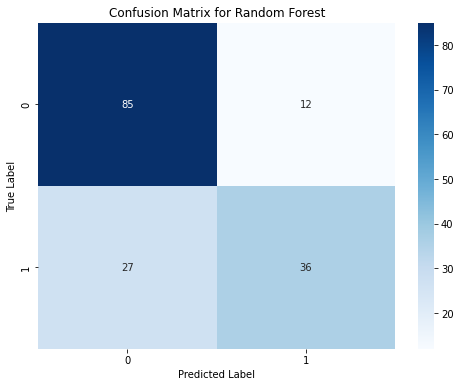

Evaluating Gradient Boosting with best hyperparameters:
GradientBoostingClassifier(learning_rate=0.05, n_estimators=150)

Performance metrics for Gradient Boosting:
Accuracy: 0.7625
Precision: 0.7272727272727273
F1 Score: 0.6779661016949152
Recall: 0.6349206349206349


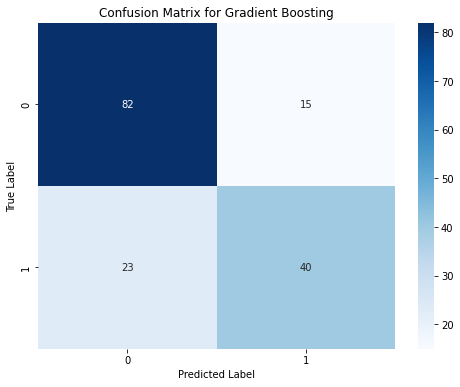

Evaluating XGBoost with best hyperparameters:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Performance metrics for XGBoost:
Accuracy: 0.75
Precision: 0.7090909090909091
F1 Score: 0.6610169491525425
Recall: 0.6190476190476191


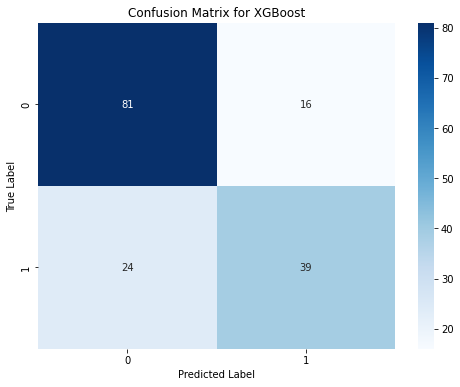

Evaluating Logistic Regression with best hyperparameters:
LogisticRegression(C=70)

Performance metrics for Logistic Regression:
Accuracy: 0.70625
Precision: 0.6212121212121212
F1 Score: 0.6356589147286822
Recall: 0.6507936507936508


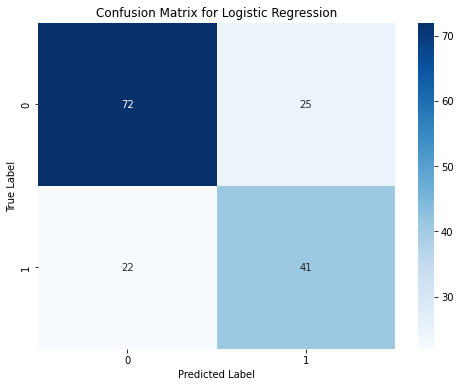

Evaluating Gaussian Naive Bayes...

Performance metrics for Gaussian Naive Bayes:
Accuracy: 0.68125
Precision: 0.5909090909090909
F1 Score: 0.6046511627906977
Recall: 0.6190476190476191


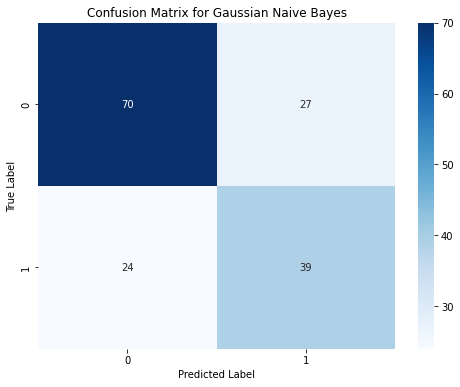

Evaluating Decision Trees...

Performance metrics for Decision Trees:
Accuracy: 0.61875
Precision: 0.5151515151515151
F1 Score: 0.5271317829457365
Recall: 0.5396825396825397


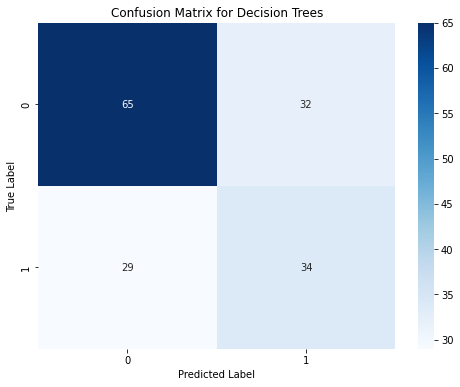

Evaluating AdaBoost...

Performance metrics for AdaBoost:
Accuracy: 0.70625
Precision: 0.6142857142857143
F1 Score: 0.6466165413533834
Recall: 0.6825396825396826


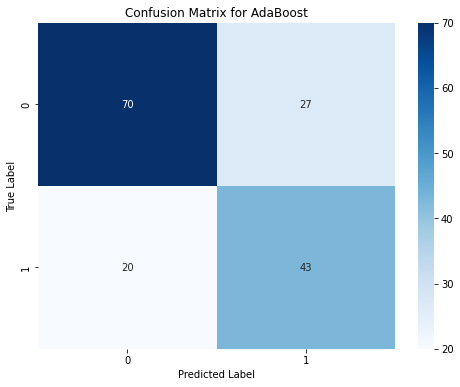

In [32]:
# Perform grid search for hyperparameter tuning
best_estimators = {}
for name, classifier in grid_search_classifiers.items():
    print(f"Performing RandomizedSearchCV for {name}...")
    random_search = RandomizedSearchCV(classifier, param_distributions[name], n_iter=40, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    random_search.fit(train_data[new_features], train_data["target"])
    best_estimators[name] = random_search.best_estimator_
    print(f"Best parameters found: {random_search.best_params_}\n")

    
    
# Use best estimators for classification
for name, classifier in best_estimators.items():
    print(f"Evaluating {name} with best hyperparameters:")
    print(classifier)
    combined, accuracy, precision, f1, recall, confusion_mat = predict(train_data, test_data, new_features, classifier)
    print(f"\nPerformance metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Use default classifiers for classification
for name, classifier in default_classifiers.items():
    print(f"Evaluating {name}...")
    combined, accuracy, precision, f1, recall, confusion_mat = predict(train_data, test_data, new_features, classifier)
    print(f"\nPerformance metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

new_features.remove("sot")

### Case 3: Correlation-based Feature Selection(without feature creation) :
Select features that have high correlation with the target variable and low correlation with each other(reduce multicollinearity)
 
- Work with the "all_matches_rolling" df
- Work with new_features - to_add_features  i.e new_features = [x for x in new_features if x not in to_add_features]
- Then remove features according to what your method suggests to remove

In [33]:
# Removing the created features
new_features = [x for x in new_features if x not in to_add_features]

#### 1. Correlation-based Feature Selection

In [34]:
# Selecting only numerical features 
numerical_features = all_matches_rolling.select_dtypes(include='number')

correlations = {}
for column in numerical_features.columns:
    if column != 'target':
    # Temporarily drop NaNs for each feature
        temp_df = all_matches_rolling[[column, 'target']].dropna()
        corr, _ = pointbiserialr(temp_df[column], temp_df['target'])
        correlations[column] = round(corr, 2)



# Sort and print the sorted correlations
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print("\nSorted Correlations:")
for feature, corr in sorted_correlations:
    print(f"{feature}: {corr}")
    
    
# Identifying features whose correlation with target is less than 0.08
irrelevant_features = [feature for feature, corr in correlations.items() if abs(corr) < 0.08]
print("\nIrrelevant Features: ", irrelevant_features)


Sorted Correlations:
gf: 0.65
gca: 0.61
ga: -0.53
g/sh: 0.47
xg: 0.45
sot: 0.42
g/sot: 0.41
xga: -0.4
sh: 0.29
kp: 0.28
sca: 0.28
sot%: 0.23
prgp_rolling_avg: 0.23
cmp_rolling_avg: 0.23
cmp%_rolling_avg: 0.22
totdist_rolling_avg: 0.22
1/3_rolling_avg: 0.22
ppa_rolling_avg: 0.22
att_rolling_avg: 0.22
prgdist: 0.21
poss_rolling_avg: 0.21
sca_rolling_avg: 0.21
cmp: 0.2
totdist: 0.2
sh_rolling_avg: 0.2
kp_rolling_avg: 0.2
att: 0.19
cmp%: 0.19
xg_rolling_avg: 0.19
prgdist_rolling_avg: 0.19
poss: 0.18
sot_rolling_avg: 0.18
1/3: 0.17
pk: 0.16
ppa: 0.16
prgp: 0.16
xga_rolling_avg: -0.16
pkatt: 0.15
gf_rolling_avg: 0.15
gca_rolling_avg: 0.14
int_rolling_avg: -0.14
venue_numeric: -0.13
ga_rolling_avg: -0.12
tklw_rolling_avg: -0.12
recov: 0.09
crs_rolling_avg: 0.09
dist: -0.08
crs: -0.07
int: -0.07
opponent_id: 0.06
fk: 0.05
crspa: -0.05
g/sh_rolling_avg: 0.05
g/sot_rolling_avg: 0.05
pk_rolling_avg: 0.05
pkatt_rolling_avg: 0.05
recov_rolling_avg: -0.05
sot%_rolling_avg: 0.04
season: 0.02
dist_ro

In [35]:
df = all_matches_rolling
cols_to_drop = ['fk', 'crspa', 'crs', 'int', 'tklw', 'hour', 'fk_rolling_avg', 'crspa_rolling_avg', 'dist_rolling_avg', 'recov_rolling_avg', 'pk_rolling_avg', 'pkatt_rolling_avg', 'sot%_rolling_avg']
df = df.drop(cols_to_drop, axis=1)    
df.shape

(2029, 63)

In [36]:
features = [x for x in new_features if x not in ['fk_rolling_avg', 'crspa_rolling_avg', 'dist_rolling_avg', 'recov_rolling_avg', 'pk_rolling_avg', 'pkatt_rolling_avg', 'sot%_rolling_avg', 'sot']]
print(features)

# not included

['venue_numeric', 'opponent_id', 'gf_rolling_avg', 'ga_rolling_avg', 'sh_rolling_avg', 'sot_rolling_avg', 'g/sh_rolling_avg', 'g/sot_rolling_avg', 'poss_rolling_avg', 'xg_rolling_avg', 'xga_rolling_avg', 'cmp%_rolling_avg', 'totdist_rolling_avg', 'prgdist_rolling_avg', 'kp_rolling_avg', '1/3_rolling_avg', 'ppa_rolling_avg', 'prgp_rolling_avg', 'sca_rolling_avg', 'gca_rolling_avg', 'cmp_rolling_avg', 'att_rolling_avg', 'crs_rolling_avg', 'int_rolling_avg', 'tklw_rolling_avg']


#### 2. Identifying Multicollinearity 
Plotting pair plot is too much time consuming and not much interpretable because of the presence of too many features and because the dataset is large
- Use correlation matrix
- Use VIF

In [37]:
X = df.select_dtypes(include='number')
# X = X.drop(['target'], axis=1)
X = X[features]
X = X.dropna()


# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                Feature          VIF
0         venue_numeric     2.023002
1           opponent_id     3.437729
2        gf_rolling_avg    67.867476
3        ga_rolling_avg     8.254528
4        sh_rolling_avg   508.864178
5       sot_rolling_avg    43.073852
6      g/sh_rolling_avg    25.051164
7     g/sot_rolling_avg    19.109549
8      poss_rolling_avg   368.441804
9        xg_rolling_avg    28.573399
10      xga_rolling_avg    17.377222
11     cmp%_rolling_avg   236.752191
12  totdist_rolling_avg   775.883526
13  prgdist_rolling_avg   326.466483
14       kp_rolling_avg   155.490503
15      1/3_rolling_avg    68.789237
16      ppa_rolling_avg    30.478530
17     prgp_rolling_avg   111.108808
18      sca_rolling_avg   573.685374
19      gca_rolling_avg    51.342515
20      cmp_rolling_avg  1875.416660
21      att_rolling_avg  2837.971328
22      crs_rolling_avg    32.038573
23      int_rolling_avg    18.910605
24     tklw_rolling_avg    22.567519


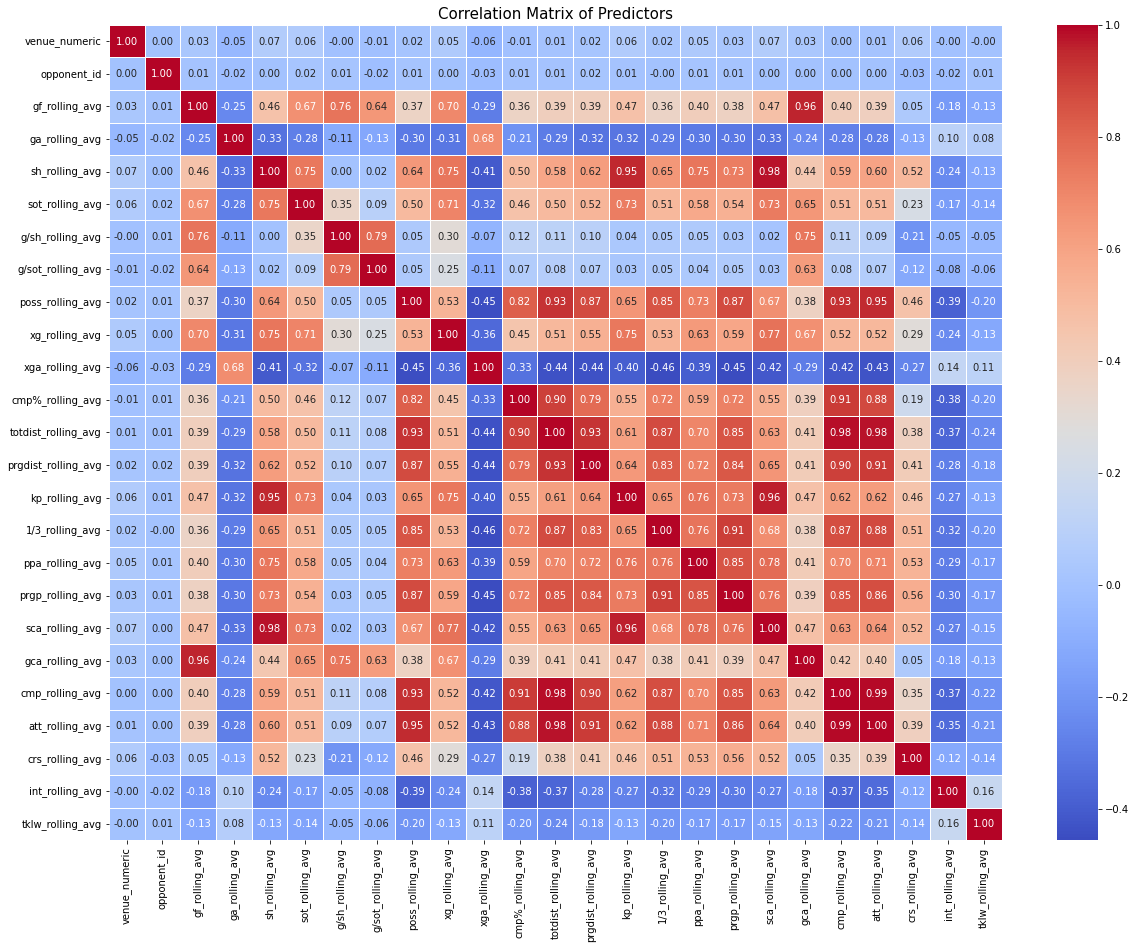

{('gf_rolling_avg', 'gca_rolling_avg'): 0.9570635990176823,
 ('sh_rolling_avg', 'kp_rolling_avg'): 0.9517006750119555,
 ('sh_rolling_avg', 'sca_rolling_avg'): 0.9816498975724909,
 ('poss_rolling_avg', 'totdist_rolling_avg'): 0.9274642849986544,
 ('poss_rolling_avg', 'cmp_rolling_avg'): 0.9338296276327991,
 ('poss_rolling_avg', 'att_rolling_avg'): 0.9482537979710322,
 ('cmp%_rolling_avg', 'cmp_rolling_avg'): 0.9145698846514322,
 ('totdist_rolling_avg', 'prgdist_rolling_avg'): 0.9284614844586524,
 ('totdist_rolling_avg', 'cmp_rolling_avg'): 0.9838234402981741,
 ('totdist_rolling_avg', 'att_rolling_avg'): 0.9804825574115223,
 ('prgdist_rolling_avg', 'cmp_rolling_avg'): 0.9016481486601778,
 ('prgdist_rolling_avg', 'att_rolling_avg'): 0.9117734095704838,
 ('kp_rolling_avg', 'sca_rolling_avg'): 0.962047217476657,
 ('1/3_rolling_avg', 'prgp_rolling_avg'): 0.9078212591851831,
 ('cmp_rolling_avg', 'att_rolling_avg'): 0.9941603653900754}

In [38]:
correlation_matrix = X.corr()

# Create a heatmap to visualize correlations
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Predictors", fontsize=15)
plt.show()


# Check for pairs who has high correlation 
pairs = {}
threshold = 0.9
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pairs[(correlation_matrix.columns[i], correlation_matrix.columns[j])] = correlation_matrix.iloc[i, j]  
            
pairs

From the above we see that : 
- **'cmp_rolling_avg'**: Appears in multiple pairs with high correlation coefficients, such as with 'totdist_rolling_avg', 'att_rolling_avg', 'cmp%_rolling_avg', 'prgdist_rolling_avg'.


- **'att_rolling_avg'**: Also appears in several highly correlated pairs, including with 'totdist_rolling_avg', 'cmp_rolling_avg', 'poss_rolling_avg'.


- **'sh_rolling_avg'**: Correlated with 'kp_rolling_avg' and 'sca_rolling_avg'.



In [61]:
remove = ['cmp_rolling_avg', 'att_rolling_avg', 'sh_rolling_avg']
features = [x for x in features if x not in remove]
print(features)

['venue_numeric', 'opponent_id', 'gf_rolling_avg', 'ga_rolling_avg', 'sot_rolling_avg', 'g/sh_rolling_avg', 'g/sot_rolling_avg', 'poss_rolling_avg', 'xg_rolling_avg', 'xga_rolling_avg', 'cmp%_rolling_avg', 'totdist_rolling_avg', 'prgdist_rolling_avg', 'kp_rolling_avg', '1/3_rolling_avg', 'ppa_rolling_avg', 'prgp_rolling_avg', 'sca_rolling_avg', 'gca_rolling_avg', 'crs_rolling_avg', 'int_rolling_avg', 'tklw_rolling_avg']


In [39]:
X = df.select_dtypes(include='number')
X = X[features]
X = X.dropna()
correlation_matrix = X.corr()
features.append("sh")
features.append("sca")

# Check for pairs who has high correlation 
pairs = {}
threshold = 0.9
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pairs[(correlation_matrix.columns[i], correlation_matrix.columns[j])] = correlation_matrix.iloc[i, j]  
            
pairs

{('gf_rolling_avg', 'gca_rolling_avg'): 0.9570635990176823,
 ('sh_rolling_avg', 'kp_rolling_avg'): 0.9517006750119555,
 ('sh_rolling_avg', 'sca_rolling_avg'): 0.9816498975724909,
 ('poss_rolling_avg', 'totdist_rolling_avg'): 0.9274642849986544,
 ('poss_rolling_avg', 'cmp_rolling_avg'): 0.9338296276327991,
 ('poss_rolling_avg', 'att_rolling_avg'): 0.9482537979710322,
 ('cmp%_rolling_avg', 'cmp_rolling_avg'): 0.9145698846514322,
 ('totdist_rolling_avg', 'prgdist_rolling_avg'): 0.9284614844586524,
 ('totdist_rolling_avg', 'cmp_rolling_avg'): 0.9838234402981741,
 ('totdist_rolling_avg', 'att_rolling_avg'): 0.9804825574115223,
 ('prgdist_rolling_avg', 'cmp_rolling_avg'): 0.9016481486601778,
 ('prgdist_rolling_avg', 'att_rolling_avg'): 0.9117734095704838,
 ('kp_rolling_avg', 'sca_rolling_avg'): 0.962047217476657,
 ('1/3_rolling_avg', 'prgp_rolling_avg'): 0.9078212591851831,
 ('cmp_rolling_avg', 'att_rolling_avg'): 0.9941603653900754}

In [40]:
# --------------------------- Train- test data ----------------------------------- #

train_data = all_matches_rolling[all_matches_rolling["date"] < '2023-12-30']
test_data = all_matches_rolling[all_matches_rolling["date"] >= '2023-12-30']
print(f"Shape of our training data is {train_data.shape}")
print(f"Shape of our testing data is {test_data.shape}\n")

Shape of our training data is (1869, 76)
Shape of our testing data is (160, 76)



In [41]:
print(f"Number of features are {len(features)} after correlation-based feature elimination")

Number of features are 27 after correlation-based feature elimination


Performing RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'n_estimators': 150, 'min_samples_split': 5, 'max_depth': 3}

Performing RandomizedSearchCV for Gradient Boosting...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05}

Performing RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

Performing RandomizedSearchCV for Logistic Regression...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'penalty': 'l2', 'C': 100}

Evaluating Random Forest with best hyperparameters:
RandomForestClassifier(max_depth=3, min_samples_split=5, n_estimators=150)

Performance metrics for Random Forest:
Accuracy: 0.71875
Precision

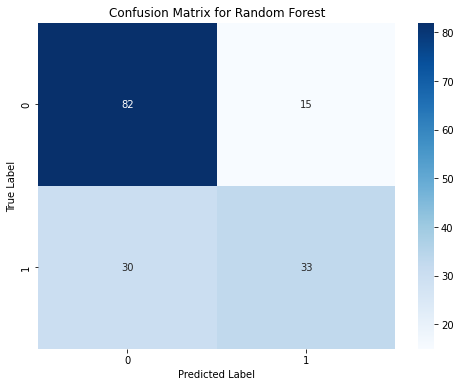

Evaluating Gradient Boosting with best hyperparameters:
GradientBoostingClassifier(learning_rate=0.05, n_estimators=50)

Performance metrics for Gradient Boosting:
Accuracy: 0.7
Precision: 0.6666666666666666
F1 Score: 0.5555555555555556
Recall: 0.47619047619047616


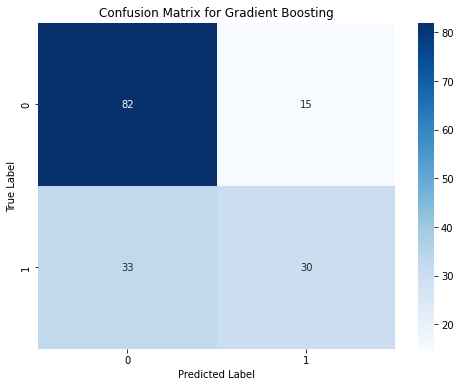

Evaluating XGBoost with best hyperparameters:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Performance metrics for XGBoost:
Accuracy: 0.69375
Precision: 0.6458333333333334
F1 Score: 0.5585585585585586
Recall: 0.49206349206349204


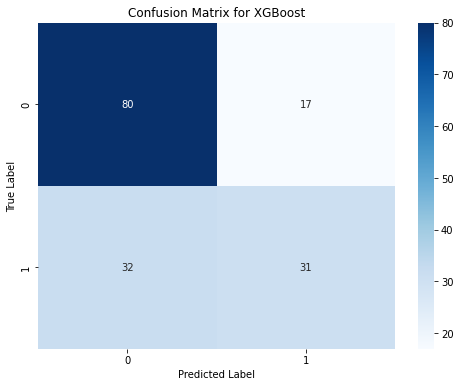

Evaluating Logistic Regression with best hyperparameters:
LogisticRegression(C=100)

Performance metrics for Logistic Regression:
Accuracy: 0.66875
Precision: 0.6041666666666666
F1 Score: 0.5225225225225225
Recall: 0.4603174603174603


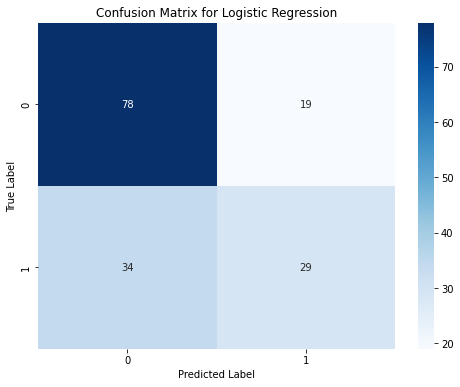

Evaluating Gaussian Naive Bayes...

Performance metrics for Gaussian Naive Bayes:
Accuracy: 0.66875
Precision: 0.578125
F1 Score: 0.5826771653543307
Recall: 0.5873015873015873


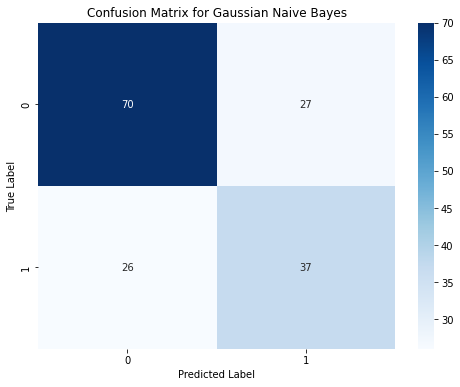

Evaluating Decision Trees...

Performance metrics for Decision Trees:
Accuracy: 0.5625
Precision: 0.4444444444444444
F1 Score: 0.4444444444444444
Recall: 0.4444444444444444


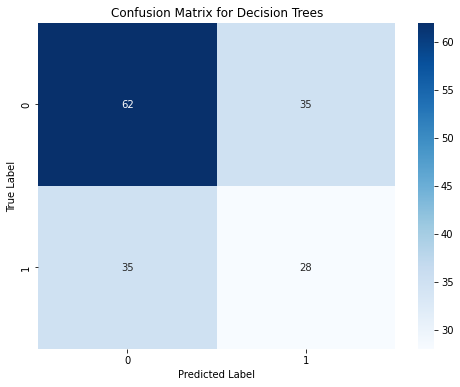

Evaluating AdaBoost...

Performance metrics for AdaBoost:
Accuracy: 0.60625
Precision: 0.5
F1 Score: 0.4424778761061947
Recall: 0.3968253968253968


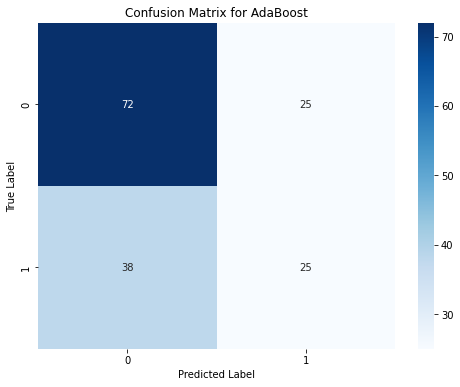

In [42]:
# Perform grid search for hyperparameter tuning
best_estimators = {}
for name, classifier in grid_search_classifiers.items():
    print(f"Performing RandomizedSearchCV for {name}...")
    random_search = RandomizedSearchCV(classifier, param_distributions[name], n_iter=40, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    random_search.fit(train_data[features], train_data["target"])
    best_estimators[name] = random_search.best_estimator_
    print(f"Best parameters found: {random_search.best_params_}\n")

    
    
# Use best estimators for classification
for name, classifier in best_estimators.items():
    print(f"Evaluating {name} with best hyperparameters:")
    print(classifier)
    combined, accuracy, precision, f1, recall, confusion_mat = predict(train_data, test_data, features, classifier)
    print(f"\nPerformance metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Use default classifiers for classification
for name, classifier in default_classifiers.items():
    print(f"Evaluating {name}...")
    combined, accuracy, precision, f1, recall, confusion_mat = predict(train_data, test_data, features, classifier)
    print(f"\nPerformance metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    
features.remove("sh")
features.remove("sca")

### Case 4: Correlation-based Feature Selection(with feature creation) :
Select features that have high correlation with the target variable and low correlation with each other(reduce multicollinearity)
 
- Work with the "new_df" df
- Work with new_features.extend(to_add_features) 
- Then remove features according to what your method suggests to remove

In [43]:
# Add back the created features
new_features.extend(to_add_features)
print(new_features)

['venue_numeric', 'opponent_id', 'gf_rolling_avg', 'ga_rolling_avg', 'sh_rolling_avg', 'sot_rolling_avg', 'sot%_rolling_avg', 'g/sh_rolling_avg', 'g/sot_rolling_avg', 'dist_rolling_avg', 'pk_rolling_avg', 'pkatt_rolling_avg', 'poss_rolling_avg', 'xg_rolling_avg', 'xga_rolling_avg', 'cmp%_rolling_avg', 'totdist_rolling_avg', 'prgdist_rolling_avg', 'kp_rolling_avg', '1/3_rolling_avg', 'ppa_rolling_avg', 'prgp_rolling_avg', 'sca_rolling_avg', 'gca_rolling_avg', 'recov_rolling_avg', 'cmp_rolling_avg', 'att_rolling_avg', 'fk_rolling_avg', 'crspa_rolling_avg', 'crs_rolling_avg', 'int_rolling_avg', 'tklw_rolling_avg', 'wins_home', 'wins_away', 'gd_home', 'gd_away']


#### 1. Correlation-based feature selection

In [44]:
numerical_features = new_df[new_features].select_dtypes(include='number')

correlations = {}
for column in numerical_features.columns:
    if column != 'target':
    # Temporarily drop NaNs for each feature
        temp_df = new_df[[column, 'target']].dropna()
        corr, _ = pointbiserialr(temp_df[column], temp_df['target'])
        correlations[column] = round(corr, 2)



# Sort and print the sorted correlations
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print("\nSorted Correlations:")
for feature, corr in sorted_correlations:
    print(f"{feature}: {corr}")
    
    
# Identifying features whose correlation with target is less than 0.08
irrelevant_features = [feature for feature, corr in correlations.items() if abs(corr) < 0.08]
print("\nIrrelevant Features: ", irrelevant_features)


Sorted Correlations:
prgp_rolling_avg: 0.23
cmp_rolling_avg: 0.23
cmp%_rolling_avg: 0.22
totdist_rolling_avg: 0.22
1/3_rolling_avg: 0.22
ppa_rolling_avg: 0.22
att_rolling_avg: 0.22
poss_rolling_avg: 0.21
sca_rolling_avg: 0.21
sh_rolling_avg: 0.2
kp_rolling_avg: 0.2
xg_rolling_avg: 0.19
prgdist_rolling_avg: 0.19
sot_rolling_avg: 0.18
xga_rolling_avg: -0.16
gf_rolling_avg: 0.15
gca_rolling_avg: 0.14
int_rolling_avg: -0.14
venue_numeric: -0.13
ga_rolling_avg: -0.12
tklw_rolling_avg: -0.12
crs_rolling_avg: 0.09
opponent_id: 0.06
g/sh_rolling_avg: 0.05
g/sot_rolling_avg: 0.05
pk_rolling_avg: 0.05
pkatt_rolling_avg: 0.05
recov_rolling_avg: -0.05
sot%_rolling_avg: 0.04
dist_rolling_avg: -0.02
fk_rolling_avg: 0.02
crspa_rolling_avg: 0.02
wins_home: 0.02
wins_away: -0.01
gd_home: 0.01
gd_away: -0.01

Irrelevant Features:  ['opponent_id', 'sot%_rolling_avg', 'g/sh_rolling_avg', 'g/sot_rolling_avg', 'dist_rolling_avg', 'pk_rolling_avg', 'pkatt_rolling_avg', 'recov_rolling_avg', 'fk_rolling_avg',

In [45]:
# Store the new_features which has the created features in the variable "features" and remove 
# features which are irrelevant according to correlation based feature selection

features = [x for x in new_features if x not in ['fk_rolling_avg', 'crspa_rolling_avg', 'dist_rolling_avg', 'recov_rolling_avg', 'pk_rolling_avg', 'pkatt_rolling_avg', 'sot%_rolling_avg', 'wins_away']]
print(features)

['venue_numeric', 'opponent_id', 'gf_rolling_avg', 'ga_rolling_avg', 'sh_rolling_avg', 'sot_rolling_avg', 'g/sh_rolling_avg', 'g/sot_rolling_avg', 'poss_rolling_avg', 'xg_rolling_avg', 'xga_rolling_avg', 'cmp%_rolling_avg', 'totdist_rolling_avg', 'prgdist_rolling_avg', 'kp_rolling_avg', '1/3_rolling_avg', 'ppa_rolling_avg', 'prgp_rolling_avg', 'sca_rolling_avg', 'gca_rolling_avg', 'cmp_rolling_avg', 'att_rolling_avg', 'crs_rolling_avg', 'int_rolling_avg', 'tklw_rolling_avg', 'wins_home', 'gd_home', 'gd_away']


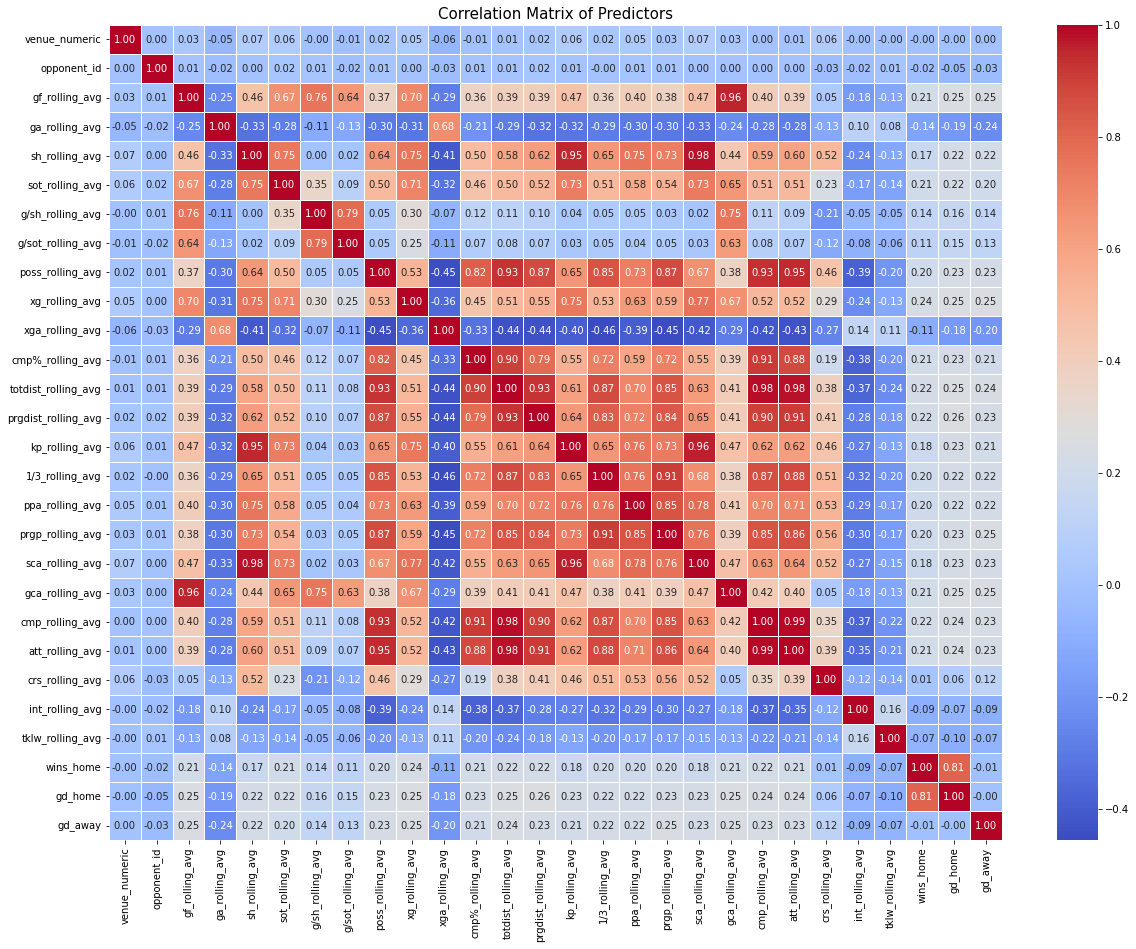

{('gf_rolling_avg', 'gca_rolling_avg'): 0.9570635990176808,
 ('sh_rolling_avg', 'kp_rolling_avg'): 0.9517006750119557,
 ('sh_rolling_avg', 'sca_rolling_avg'): 0.9816498975724915,
 ('poss_rolling_avg', 'totdist_rolling_avg'): 0.9274642849986529,
 ('poss_rolling_avg', 'cmp_rolling_avg'): 0.9338296276327993,
 ('poss_rolling_avg', 'att_rolling_avg'): 0.9482537979710318,
 ('cmp%_rolling_avg', 'cmp_rolling_avg'): 0.9145698846514315,
 ('totdist_rolling_avg', 'prgdist_rolling_avg'): 0.9284614844586564,
 ('totdist_rolling_avg', 'cmp_rolling_avg'): 0.9838234402981719,
 ('totdist_rolling_avg', 'att_rolling_avg'): 0.9804825574115222,
 ('prgdist_rolling_avg', 'cmp_rolling_avg'): 0.9016481486601768,
 ('prgdist_rolling_avg', 'att_rolling_avg'): 0.911773409570486,
 ('kp_rolling_avg', 'sca_rolling_avg'): 0.9620472174766552,
 ('1/3_rolling_avg', 'prgp_rolling_avg'): 0.9078212591851801,
 ('cmp_rolling_avg', 'att_rolling_avg'): 0.9941603653900758}

In [46]:
X = new_df.select_dtypes(include='number')
# X = X.drop(['target'], axis=1)
X = X[features]
X = X.dropna()
features.append("sot")

correlation_matrix = X.corr()

# Create a heatmap to visualize correlations
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Predictors", fontsize=15)
plt.show()


# Check for pairs who has high correlation 
pairs = {}
threshold = 0.9
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pairs[(correlation_matrix.columns[i], correlation_matrix.columns[j])] = correlation_matrix.iloc[i, j]  
            
pairs

In [47]:
remove = ['cmp_rolling_avg', 'att_rolling_avg', 'sh_rolling_avg']
features = [x for x in features if x not in remove]
print(len(features))

26


In [48]:
# --------------------------- Train- test data ----------------------------------- #

train_data = new_df[new_df["date"] < '2023-12-30']
test_data = new_df[new_df["date"] >= '2023-12-30']
print(f"Shape of our training data is {train_data.shape}")
print(f"Shape of our testing data is {test_data.shape}\n")

Shape of our training data is (1869, 81)
Shape of our testing data is (160, 81)



Performing RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'n_estimators': 200, 'min_samples_split': 20, 'max_depth': 10}

Performing RandomizedSearchCV for Gradient Boosting...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}

Performing RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

Performing RandomizedSearchCV for Logistic Regression...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'penalty': 'l2', 'C': 0.01}

Evaluating Random Forest with best hyperparameters:
RandomForestClassifier(max_depth=10, min_samples_split=20, n_estimators=200)

Performance metrics for Random Forest:
Accuracy: 0.8125
Prec

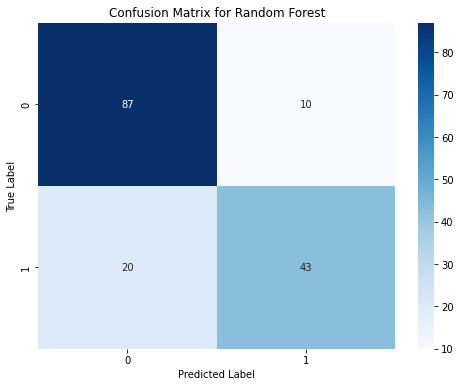

Evaluating Gradient Boosting with best hyperparameters:
GradientBoostingClassifier(learning_rate=0.05, n_estimators=200)

Performance metrics for Gradient Boosting:
Accuracy: 0.7875
Precision: 0.7543859649122807
F1 Score: 0.7166666666666668
Recall: 0.6825396825396826


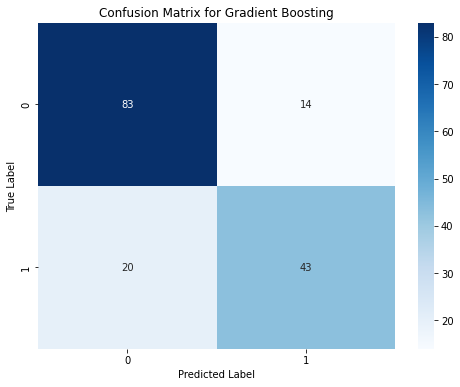

Evaluating XGBoost with best hyperparameters:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Performance metrics for XGBoost:
Accuracy: 0.7875
Precision: 0.7636363636363637
F1 Score: 0.711864406779661
Recall: 0.6666666666666666


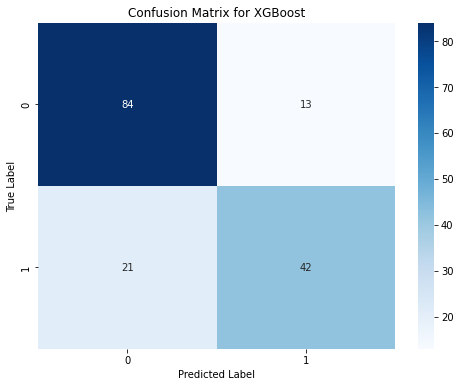

Evaluating Logistic Regression with best hyperparameters:
LogisticRegression(C=0.01)

Performance metrics for Logistic Regression:
Accuracy: 0.79375
Precision: 0.8125
F1 Score: 0.7027027027027026
Recall: 0.6190476190476191


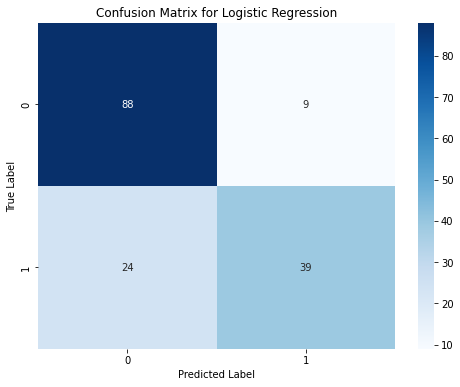

Evaluating Gaussian Naive Bayes...

Performance metrics for Gaussian Naive Bayes:
Accuracy: 0.78125
Precision: 0.7333333333333333
F1 Score: 0.7154471544715446
Recall: 0.6984126984126984


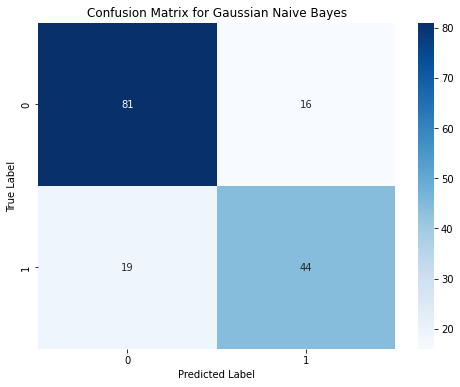

Evaluating Decision Trees...

Performance metrics for Decision Trees:
Accuracy: 0.7125
Precision: 0.6491228070175439
F1 Score: 0.6166666666666668
Recall: 0.5873015873015873


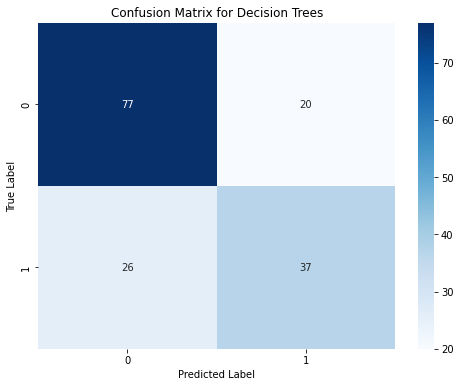

Evaluating AdaBoost...

Performance metrics for AdaBoost:
Accuracy: 0.7875
Precision: 0.7735849056603774
F1 Score: 0.706896551724138
Recall: 0.6507936507936508


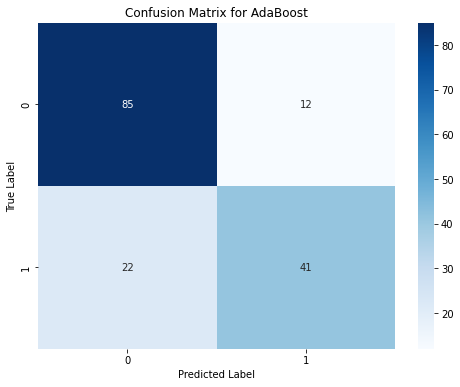

In [51]:
# Perform grid search for hyperparameter tuning
features.append("ga")
best_estimators = {}
for name, classifier in grid_search_classifiers.items():
    print(f"Performing RandomizedSearchCV for {name}...")
    random_search = RandomizedSearchCV(classifier, param_distributions[name], n_iter=40, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    random_search.fit(train_data[features], train_data["target"])
    best_estimators[name] = random_search.best_estimator_
    print(f"Best parameters found: {random_search.best_params_}\n")

    
    
# Use best estimators for classification
for name, classifier in best_estimators.items():
    print(f"Evaluating {name} with best hyperparameters:")
    print(classifier)
    combined, accuracy, precision, f1, recall, confusion_mat = predict(train_data, test_data, features, classifier)
    print(f"\nPerformance metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Use default classifiers for classification
for name, classifier in default_classifiers.items():
    print(f"Evaluating {name}...")
    combined, accuracy, precision, f1, recall, confusion_mat = predict(train_data, test_data, features, classifier)
    print(f"\nPerformance metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Case 5 : Recursive Feature elimination(after feature creation and correlation based feature selection)
- Work with the 'features' variable
- Apply RFE

In [52]:
train_data = new_df[new_df["date"] < '2023-12-30']
test_data = new_df[new_df["date"] >= '2023-12-30']
print(f"Shape of our training data is {train_data.shape}")
print(f"Shape of our testing data is {test_data.shape}\n")

Shape of our training data is (1869, 81)
Shape of our testing data is (160, 81)



Performing RandomizedSearchCV for Random Forest...
Performing RandomizedSearchCV for Gradient Boosting...
Performing RandomizedSearchCV for XGBoost...
Performing RandomizedSearchCV for Logistic Regression...
Evaluating Random Forest with best hyperparameters:
RandomForestClassifier()

Performance metrics for Random Forest:
Accuracy: 0.76875
Precision: 0.75
F1 Score: 0.6782608695652174
Recall: 0.6190476190476191


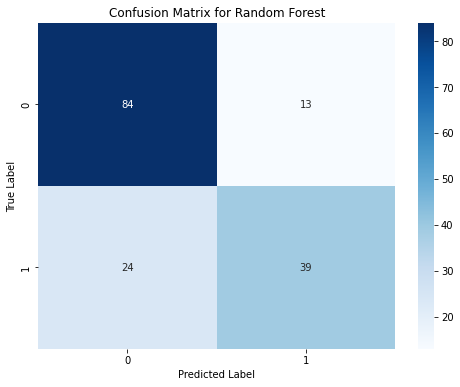

Evaluating Gradient Boosting with best hyperparameters:
GradientBoostingClassifier()

Performance metrics for Gradient Boosting:
Accuracy: 0.78125
Precision: 0.75
F1 Score: 0.7058823529411765
Recall: 0.6666666666666666


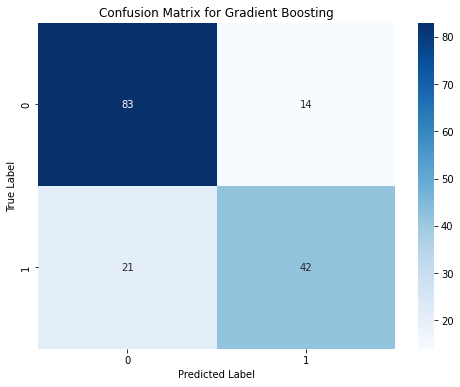

Evaluating XGBoost with best hyperparameters:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Performance metrics for XGBoost:
Accuracy: 0.71875
Precision: 0.6551724137931034
F1 Score: 0.628099173553719
Recall: 0.6031746031746031


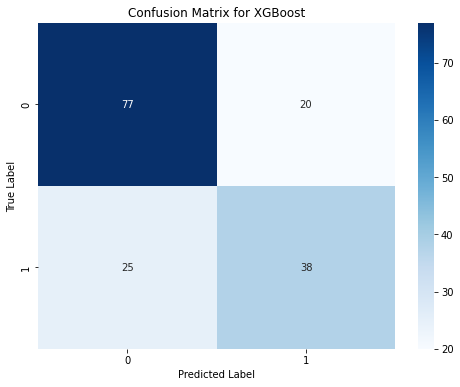

Evaluating Logistic Regression with best hyperparameters:
LogisticRegression()

Performance metrics for Logistic Regression:
Accuracy: 0.775
Precision: 0.7454545454545455
F1 Score: 0.6949152542372882
Recall: 0.6507936507936508


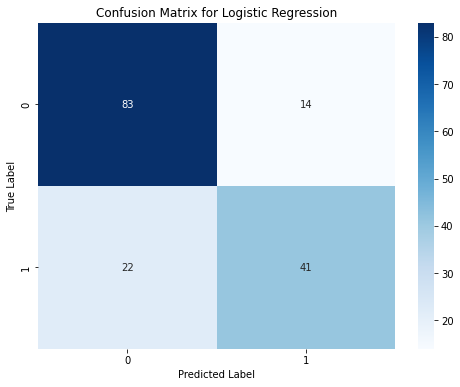

In [53]:
from sklearn.feature_selection import RFECV

# Perform grid search for hyperparameter tuning
best_estimators = {}
features.append("xga")
for name, classifier in grid_search_classifiers.items():
    print(f"Performing RandomizedSearchCV for {name}...")
    # Initialize RFECV with the classifier and scoring method
    rfecv = RFECV(estimator=classifier, cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)
    rfecv.fit(train_data[features], train_data["target"])
    
    # Select the best features based on RFECV
    selected_features = train_data[features].columns[rfecv.support_]
    
    # Refit the classifier with the selected features
    classifier.fit(train_data[selected_features], train_data["target"])
    
    # Save the best estimator
    best_estimators[name] = classifier
    
#     print(f"Best parameters found: {rfecv.grid_scores_}\n")

# Use best estimators for classification
for name, classifier in best_estimators.items():
    print(f"Evaluating {name} with best hyperparameters:")
    selected_features = list(set(selected_features))  # Remove duplicate feature names
    print(classifier)
    combined, accuracy, precision, f1, recall, confusion_mat = predict(train_data, test_data, selected_features, classifier)
    print(f"\nPerformance metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    


Evaluating Decision Trees with RFE...

Performance metrics for Decision Trees with RFE:
Accuracy: 0.70625
Precision: 0.6481481481481481
F1 Score: 0.5982905982905983
Recall: 0.5555555555555556


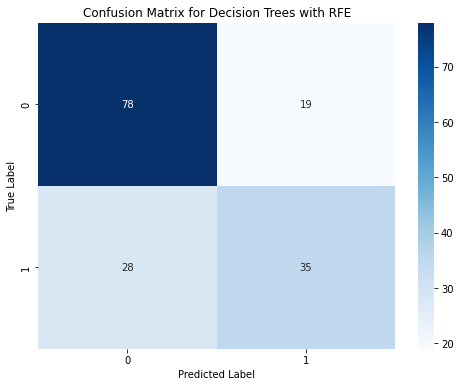

Evaluating AdaBoost with RFE...

Performance metrics for AdaBoost with RFE:
Accuracy: 0.8
Precision: 0.7719298245614035
F1 Score: 0.7333333333333333
Recall: 0.6984126984126984


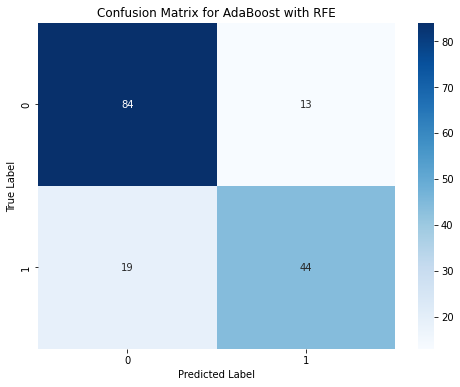

In [54]:
from sklearn.feature_selection import RFE

# Gaussian Naive Bayes dont have RFE functionality
default_classifiers = {
    'Decision Trees': DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, learning_rate=1.0, base_estimator=None)
}

# Dictionary to store the best estimators after RFE
best_estimators_rfe = {}

# Iterate through each classifier in default_classifiers
for name, classifier in default_classifiers.items():
    print(f"Evaluating {name} with RFE...")
    
    # Initialize RFE with the classifier
    rfe = RFE(estimator=classifier, n_features_to_select=15, step=1)
    
    # Fit RFE on training data
    rfe.fit(train_data[features], train_data["target"])
    
    # Select the best features based on RFE
    selected_features_rfe = train_data[features].columns[rfe.support_]
    
    # Refit the classifier with the selected features
    classifier.fit(train_data[selected_features_rfe], train_data["target"])
    
    # Save the best estimator after RFE
    best_estimators_rfe[name] = classifier

    # Evaluate the performance metrics
    combined, accuracy, precision, f1, recall, confusion_mat = predict(train_data, test_data, selected_features_rfe, classifier)
    print(f"\nPerformance metrics for {name} with RFE:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name} with RFE")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


### Case 6 : Recursive Feature elimination(feature creation but without correlation based feature selection)

In [61]:
print(f"Number of features = {len(new_features)} and they are: \n")
print(new_features)
print("\nThe number of features are large because we did not remove features based off correlation")
new_features.append("sh")

Number of features = 36 and they are: 

['venue_numeric', 'opponent_id', 'gf_rolling_avg', 'ga_rolling_avg', 'sh_rolling_avg', 'sot_rolling_avg', 'sot%_rolling_avg', 'g/sh_rolling_avg', 'g/sot_rolling_avg', 'dist_rolling_avg', 'pk_rolling_avg', 'pkatt_rolling_avg', 'poss_rolling_avg', 'xg_rolling_avg', 'xga_rolling_avg', 'cmp%_rolling_avg', 'totdist_rolling_avg', 'prgdist_rolling_avg', 'kp_rolling_avg', '1/3_rolling_avg', 'ppa_rolling_avg', 'prgp_rolling_avg', 'sca_rolling_avg', 'gca_rolling_avg', 'recov_rolling_avg', 'cmp_rolling_avg', 'att_rolling_avg', 'fk_rolling_avg', 'crspa_rolling_avg', 'crs_rolling_avg', 'int_rolling_avg', 'tklw_rolling_avg', 'wins_home', 'wins_away', 'gd_home', 'gd_away']

The number of features are large because we did not remove features based off correlation


Performing RandomizedSearchCV for Random Forest...
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Performing RandomizedSearchCV for Gradient Boosting...
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 feat

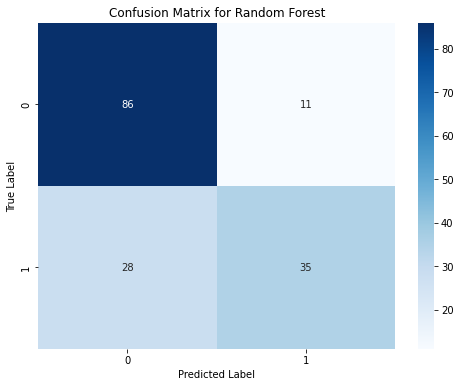

Evaluating Gradient Boosting with best hyperparameters:
GradientBoostingClassifier()

Performance metrics for Gradient Boosting:
Accuracy: 0.76875
Precision: 0.7407407407407407
F1 Score: 0.6837606837606837
Recall: 0.6349206349206349


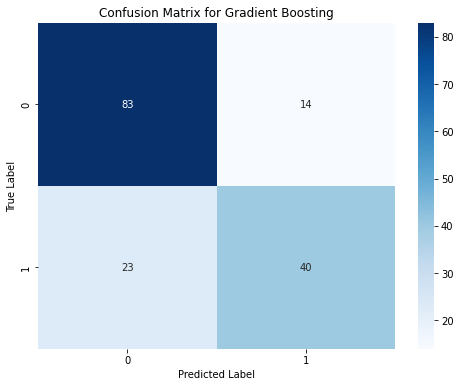

Evaluating XGBoost with best hyperparameters:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Performance metrics for XGBoost:
Accuracy: 0.75625
Precision: 0.7307692307692307
F1 Score: 0.6608695652173913
Recall: 0.6031746031746031


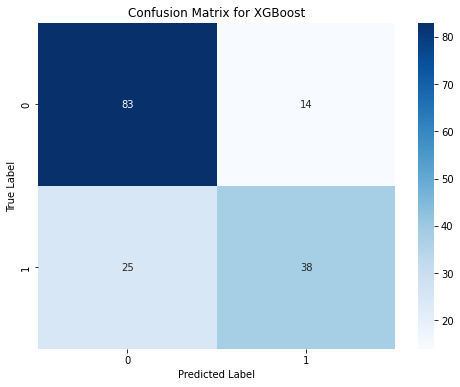

Evaluating Logistic Regression with best hyperparameters:
LogisticRegression()

Performance metrics for Logistic Regression:
Accuracy: 0.76875
Precision: 0.7407407407407407
F1 Score: 0.6837606837606837
Recall: 0.6349206349206349


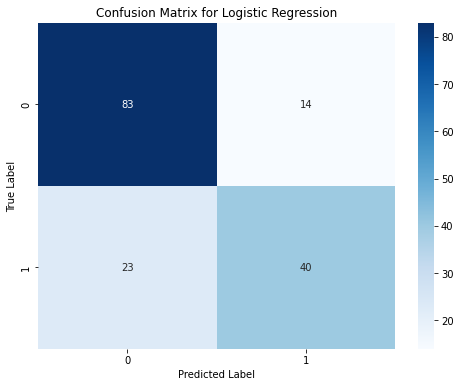

In [65]:
from sklearn.feature_selection import RFECV

# Perform grid search for hyperparameter tuning
best_estimators = {}
new_features.append("xga")
new_features.append("sot")
for name, classifier in grid_search_classifiers.items():
    print(f"Performing RandomizedSearchCV for {name}...")
    # Initialize RFECV with the classifier and scoring method
    rfecv = RFECV(estimator=classifier, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    rfecv.fit(train_data[new_features], train_data["target"])
    
    # Select the best features based on RFECV
    selected_features = train_data[new_features].columns[rfecv.support_]
    
    # Refit the classifier with the selected features
    classifier.fit(train_data[selected_features], train_data["target"])
    
    # Save the best estimator
    best_estimators[name] = classifier
    
#     print(f"Best parameters found: {rfecv.grid_scores_}\n")

# Use best estimators for classification
for name, classifier in best_estimators.items():
    print(f"Evaluating {name} with best hyperparameters:")
    print(classifier)
    combined, accuracy, precision, f1, recall, confusion_mat = predict(train_data, test_data, selected_features, classifier)
    print(f"\nPerformance metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Evaluating Decision Trees with RFE...

Performance metrics for Decision Trees with RFE:
Accuracy: 0.51875
Precision: 0.390625
F1 Score: 0.3937007874015748
Recall: 0.3968253968253968


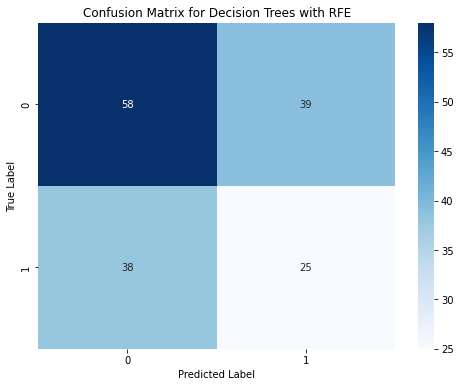

Evaluating AdaBoost with RFE...

Performance metrics for AdaBoost with RFE:
Accuracy: 0.6875
Precision: 0.6382978723404256
F1 Score: 0.5454545454545455
Recall: 0.47619047619047616


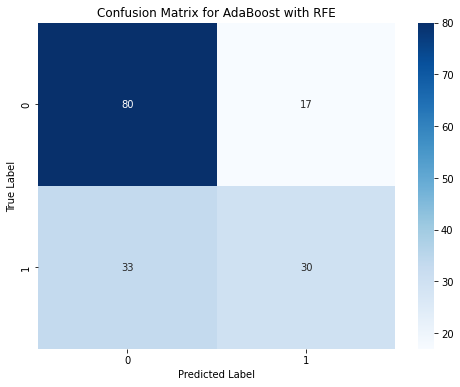

In [63]:
from sklearn.feature_selection import RFE

default_classifiers = {
    'Decision Trees': DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, learning_rate=1.0, base_estimator=None)
}

# Dictionary to store the best estimators after RFE
best_estimators_rfe = {}

# Iterate through each classifier in default_classifiers
for name, classifier in default_classifiers.items():
    print(f"Evaluating {name} with RFE...")
    
    # Initialize RFE with the classifier
    rfe = RFE(estimator=classifier, n_features_to_select=15, step=1)
    
    # Fit RFE on training data
    rfe.fit(train_data[new_features], train_data["target"])
    
    # Select the best features based on RFE
    selected_features_rfe = train_data[new_features].columns[rfe.support_]
    
    # Refit the classifier with the selected features
    classifier.fit(train_data[selected_features_rfe], train_data["target"])
    
    # Save the best estimator after RFE
    best_estimators_rfe[name] = classifier

    # Evaluate the performance metrics
    combined, accuracy, precision, f1, recall, confusion_mat = predict(train_data, test_data, selected_features_rfe, classifier)
    print(f"\nPerformance metrics for {name} with RFE:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name} with RFE")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


## Try Deep Learning

In [122]:
train_data = new_df[new_df["date"] < '2023-12-30']
val_data =  train_data[train_data["date"] >= '2023-10-30']
train_data = train_data[train_data["date"] < '2023-10-30']
test_data = new_df[new_df["date"] >= '2023-12-30']
print(f"Shape of our training data is {train_data.shape}")
print(f"Shape of our validation data is {val_data.shape}")
print(f"Shape of our testing data is {test_data.shape}\n")

Shape of our training data is (1693, 81)
Shape of our validation data is (176, 81)
Shape of our testing data is (160, 81)



In [123]:
# Define features and target variable
new_features = features
X_train = torch.tensor(train_data[new_features].values, dtype=torch.float32)
y_train = torch.tensor(train_data["target"].values, dtype=torch.float32)

X_val = torch.tensor(val_data[new_features].values, dtype=torch.float32)
y_val = torch.tensor(val_data["target"].values, dtype=torch.float32)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.numpy())
X_val_scaled = scaler.transform(X_val.numpy())


# Define the deep learning model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train_scaled.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = NeuralNetwork()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train the model
def train_model(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs=20, batch_size=64):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            inputs = X_train[i:i+batch_size]
            labels = y_train[i:i+batch_size]

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validate the model
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val.view(-1, 1))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(X_train)}")

train_model(model, torch.tensor(X_train_scaled), y_train, torch.tensor(X_val_scaled), y_val, criterion, optimizer)

# Evaluate the model on the test set
X_test_scaled = torch.tensor(scaler.transform(test_data[new_features].values), dtype=torch.float32)
y_test = torch.tensor(test_data["target"].values, dtype=torch.float32)

with torch.no_grad():
    y_pred = (model(X_test_scaled) > 0.45).float()
y_pred = y_pred.numpy()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


Epoch 1/20, Loss: 0.010216054765697914
Epoch 2/20, Loss: 0.009338574003201578
Epoch 3/20, Loss: 0.008711327991750348
Epoch 4/20, Loss: 0.008318944999753409
Epoch 5/20, Loss: 0.008028555377587298
Epoch 6/20, Loss: 0.00796118478977814
Epoch 7/20, Loss: 0.007837165672963565
Epoch 8/20, Loss: 0.007923752720793957
Epoch 9/20, Loss: 0.007709073601428109
Epoch 10/20, Loss: 0.007669114179323921
Epoch 11/20, Loss: 0.007691267233097687
Epoch 12/20, Loss: 0.007645081590071136
Epoch 13/20, Loss: 0.007461244177691555
Epoch 14/20, Loss: 0.007525534141859358
Epoch 15/20, Loss: 0.007530100251962219
Epoch 16/20, Loss: 0.0074021910783178485
Epoch 17/20, Loss: 0.007400112150691349
Epoch 18/20, Loss: 0.00750254229265631
Epoch 19/20, Loss: 0.007365250421992717
Epoch 20/20, Loss: 0.007353678354481868
Evaluation Metrics:
Accuracy: 0.7375
Precision: 0.6779661016949152
Recall: 0.6349206349206349
F1 Score: 0.6557377049180327
Confusion Matrix:
[[78 19]
 [23 40]]


### Simpler architecture

In [124]:
# Define the deep learning model with reduced complexity
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train_scaled.shape[1], 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Create the simple model
simple_model = SimpleNeuralNetwork()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(simple_model.parameters())

# Train the simple model
train_model(simple_model, torch.tensor(X_train_scaled), y_train, torch.tensor(X_val_scaled), y_val, criterion, optimizer)

# Evaluate the simple model on the test set
with torch.no_grad():
    y_pred_simple = (simple_model(X_test_scaled) > 0.45).float()
y_pred_simple = y_pred_simple.numpy()

accuracy_simple = accuracy_score(y_test, y_pred_simple)
precision_simple = precision_score(y_test, y_pred_simple)
recall_simple = recall_score(y_test, y_pred_simple)
f1_simple = f1_score(y_test, y_pred_simple)
conf_matrix_simple = confusion_matrix(y_test, y_pred_simple)

print("Evaluation Metrics for Simple Model:")
print(f"Accuracy: {accuracy_simple}")
print(f"Precision: {precision_simple}")
print(f"Recall: {recall_simple}")
print(f"F1 Score: {f1_simple}")
print("Confusion Matrix:")
print(conf_matrix_simple)


Epoch 1/20, Loss: 0.010954381302835247
Epoch 2/20, Loss: 0.01011758958244211
Epoch 3/20, Loss: 0.00965174506278131
Epoch 4/20, Loss: 0.009305720296190536
Epoch 5/20, Loss: 0.008992685749906798
Epoch 6/20, Loss: 0.00863237463364711
Epoch 7/20, Loss: 0.008443956870125795
Epoch 8/20, Loss: 0.008314193404079961
Epoch 9/20, Loss: 0.008139158766859745
Epoch 10/20, Loss: 0.008052409874639494
Epoch 11/20, Loss: 0.008006852386410393
Epoch 12/20, Loss: 0.0079201268889252
Epoch 13/20, Loss: 0.007836430455127273
Epoch 14/20, Loss: 0.0078042671304444765
Epoch 15/20, Loss: 0.007763162528137729
Epoch 16/20, Loss: 0.007645989531113139
Epoch 17/20, Loss: 0.0076385415910055
Epoch 18/20, Loss: 0.007809137671358544
Epoch 19/20, Loss: 0.0076700958076202155
Epoch 20/20, Loss: 0.007650763201277001
Evaluation Metrics for Simple Model:
Accuracy: 0.725
Precision: 0.6610169491525424
Recall: 0.6190476190476191
F1 Score: 0.6393442622950819
Confusion Matrix:
[[77 20]
 [24 39]]


## Plotting the average results

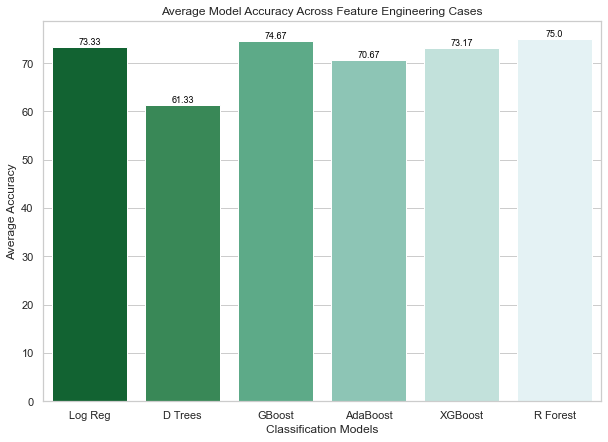

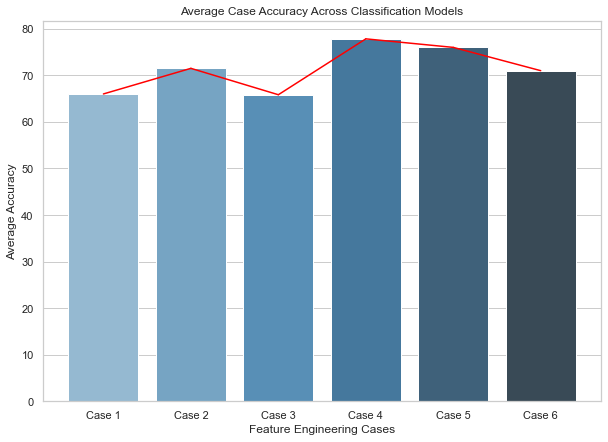

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Model accuracies for each case
lr = [68, 71, 67, 79, 78, 77]
dt = [57, 61, 56, 71, 71, 52]
gb = [68, 76, 70, 79, 78, 77]
ab = [65, 71, 61, 78, 80, 69]
xgb = [69, 75, 69, 79, 72, 75]
rf = [69, 75, 72, 81, 77, 76]

# Compute average model accuracy across 6 cases
avg_model_accuracy = np.mean([lr, dt, gb, ab, xgb, rf], axis=1)

# Compute average case accuracy across models
avg_case_accuracy = np.mean([lr, dt, gb, ab, xgb, rf], axis=0)

# Set seaborn style
sns.set(style="whitegrid")

# Plot for average model accuracy across cases
plt.figure(figsize=(10, 7))
models = ['Log Reg', 'D Trees', 'GBoost', 'AdaBoost', 'XGBoost', 'R Forest']
bar_plot = sns.barplot(x=models, y=avg_model_accuracy, palette="BuGn_r")
plt.title('Average Model Accuracy Across Feature Engineering Cases')
plt.xlabel('Classification Models')
plt.ylabel('Average Accuracy')

# Add values on top of the bars
for bar, value in zip(bar_plot.patches, avg_model_accuracy):
    bar_plot.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 2), 
                  ha='center', va='bottom', fontsize=9, color='black')

plt.show()

# Plot for average case accuracy across models with lines connecting the middle of each bar
plt.figure(figsize=(10, 7))
cases = ['Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6']
bar_plot = sns.barplot(x=cases, y=avg_case_accuracy, palette="Blues_d")
plt.title('Average Case Accuracy Across Classification Models')
plt.xlabel('Feature Engineering Cases')
plt.ylabel('Average Accuracy')

# Calculate the midpoints of each bar
bar_centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_plot.patches]

# Add line plots joining midpoints of bars
for i in range(len(bar_centers)-1):
    plt.plot([bar_centers[i], bar_centers[i+1]], [avg_case_accuracy[i], avg_case_accuracy[i+1]], color='red', linestyle='-')

plt.show()
